El objetivo de este documento es probar una red bayesiana para realizar predicción sobre los datos de sensores. Para ello aprendemos una red bayesiana y ajustamos sus parámetros, considerando los datos de entrada como continuos (no realizamos discretización), por eso veremos que se samplean la distribución de cada nodo/variable a una gaussiana.

El dataset utilizado es de 20 sensores cercanos entre sí, distribuidos en una parcela de 100x100, más los sensores de una estación meteorológica (variables cuyo nombre empieza con Est\_ ). Estos datos se han agrupado de forma diaria (dataset sensores.csv) creando variables como la media, máxima, mínima, temperatura a las 15,12 y 18 hs de cada sensor.




In [1]:
library(bnlearn)                       
library(forecast)


Attaching package: ‘bnlearn’

The following object is masked from ‘package:stats’:

    sigma

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: timeDate
This is forecast 5.8 



### Preprocesando el dataset 

In [2]:
library(readr)
sensores <- read_csv("../data/sensores.csv")
colnames(sensores)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  .default = col_double(),
  X1 = col_datetime(format = "")
)
See spec(...) for full column specifications.


[1] "X1"              "S10.max"         "S11.max"         "S12.max"        
  [5] "S13.max"         "S14.max"         "S15.max"         "S16.max"        
  [9] "S17.max"         "S18.max"         "S19.max"         "S1.max"         
 [13] "S20.max"         "S2.max"          "S3.max"          "S4.max"         
 [17] "S5.max"          "S6.max"          "S7.max"          "S8.max"         
 [21] "S9.max"          "S10.media"       "S11.media"       "S12.media"      
 [25] "S13.media"       "S14.media"       "S15.media"       "S16.media"      
 [29] "S17.media"       "S18.media"       "S19.media"       "S1.media"       
 [33] "S20.media"       "S2.media"        "S3.media"        "S4.media"       
 [37] "S5.media"        "S6.media"        "S7.media"        "S8.media"       
 [41] "S9.media"        "S10.min"         "S11.min"         "S12.min"        
 [45] "S13.min"         "S14.min"         "S15.min"         "S16.min"        
 [49] "S17.min"         "S18.min"         "S19.min"         "S1.min"         
 [53] "S20.min"         "S2.min"          "S3.min"          "S4.min"         
 [57] "S5.min"          "S6.min"          "S7.min"          "S8.min"         
 [61] "S9.min"          "S10.15hs"        "S11.15hs"        "S12.15hs"       
 [65] "S13.15hs"        "S14.15hs"        "S15.15hs"        "S16.15hs"       
 [69] "S17.15hs"        "S18.15hs"        "S19.15hs"        "S1.15hs"        
 [73] "S20.15hs"        "S2.15hs"         "S3.15hs"         "S4.15hs"        
 [77] "S5.15hs"         "S6.15hs"         "S7.15hs"         "S8.15hs"        
 [81] "S9.15hs"         "S10.12hs"        "S11.12hs"        "S12.12hs"       
 [85] "S13.12hs"        "S14.12hs"        "S15.12hs"        "S16.12hs"       
 [89] "S17.12hs"        "S18.12hs"        "S19.12hs"        "S1.12hs"        
 [93] "S20.12hs"        "S2.12hs"         "S3.12hs"         "S4.12hs"        
 [97] "S5.12hs"         "S6.12hs"         "S7.12hs"         "S8.12hs"        
[101] "S9.12hs"         "S10.18hs"        "S11.18hs"        "S12.18hs"       
[105] "S13.18hs"        "S14.18hs"        "S15.18hs"        "S16.18hs"       
[109] "S17.18hs"        "S18.18hs"        "S19.18hs"        "S1.18hs"        
[113] "S20.18hs"        "S2.18hs"         "S3.18hs"         "S4.18hs"        
[117] "S5.18hs"         "S6.18hs"         "S7.18hs"         "S8.18hs"        
[121] "S9.18hs"         "Est.humedad_min" "Est.humedad_med" "Est.humedad_max"
[125] "Est.temp_min"    "Est.temp_max"    "Est.temp_med"

In [3]:
nrow(sensores)

[1] 465

Procedemos a armar un dataset con las variables, colocando los datos de hace dos días, luego hace un día y luego día presente. Por ello, desfazamos el dataset para que queden primero las variables en T-2, T-1 y luego en t o tiempo presente.

Más adelante nos preguntaremos por la predicción de la temperatura mínima en t (por ejemplo para un sensor especifico S11.min_t

In [4]:
# como denomino a las variables que quiero predecir

pred_sensores = c("S10.min_t","S11.min_t","S12.min_t","S13.min_t","S14.min_t","S15.min_t","S16.min_t","S18.min_t", "S19.min_t","S1.min_t","S20.min_t","S2.min_t","S3.min_t","S4.min_t","S5.min_t",
                  "S6.min_t","S7.min_t","S8.min_t","S9.min_t")

In [5]:

#, descarto la primer columna que es el timestamp o fecha
sensores_T_2 <- sensores[1:(nrow(sensores)-2),-1] 
sensores_T_1 <- sensores[2:(nrow(sensores)-1),-1] # no incluyo la primera fila
sensores_t <- sensores[3:nrow(sensores),] 


# renombro las columnas 
colnames(sensores_T_2) <- paste(colnames(sensores_T_2),"_T_2",sep="")
colnames(sensores_T_1) <- paste(colnames(sensores_T_1),"_T_1",sep="")
colnames(sensores_t) <- paste(colnames(sensores_t),"_t",sep="")


#del tiempo presente solo me interesa la temperatura mínima
sensores_t <- sensores_t[,pred_sensores]

# creo dataset de datos de T-2, T-1 y t
df <- cbind.data.frame(sensores_T_2,sensores_T_1,sensores_t)

colnames(df)

[1] "S10.max_T_2"         "S11.max_T_2"         "S12.max_T_2"        
  [4] "S13.max_T_2"         "S14.max_T_2"         "S15.max_T_2"        
  [7] "S16.max_T_2"         "S17.max_T_2"         "S18.max_T_2"        
 [10] "S19.max_T_2"         "S1.max_T_2"          "S20.max_T_2"        
 [13] "S2.max_T_2"          "S3.max_T_2"          "S4.max_T_2"         
 [16] "S5.max_T_2"          "S6.max_T_2"          "S7.max_T_2"         
 [19] "S8.max_T_2"          "S9.max_T_2"          "S10.media_T_2"      
 [22] "S11.media_T_2"       "S12.media_T_2"       "S13.media_T_2"      
 [25] "S14.media_T_2"       "S15.media_T_2"       "S16.media_T_2"      
 [28] "S17.media_T_2"       "S18.media_T_2"       "S19.media_T_2"      
 [31] "S1.media_T_2"        "S20.media_T_2"       "S2.media_T_2"       
 [34] "S3.media_T_2"        "S4.media_T_2"        "S5.media_T_2"       
 [37] "S6.media_T_2"        "S7.media_T_2"        "S8.media_T_2"       
 [40] "S9.media_T_2"        "S10.min_T_2"         "S11.min_T_2"        
 [43] "S12.min_T_2"         "S13.min_T_2"         "S14.min_T_2"        
 [46] "S15.min_T_2"         "S16.min_T_2"         "S17.min_T_2"        
 [49] "S18.min_T_2"         "S19.min_T_2"         "S1.min_T_2"         
 [52] "S20.min_T_2"         "S2.min_T_2"          "S3.min_T_2"         
 [55] "S4.min_T_2"          "S5.min_T_2"          "S6.min_T_2"         
 [58] "S7.min_T_2"          "S8.min_T_2"          "S9.min_T_2"         
 [61] "S10.15hs_T_2"        "S11.15hs_T_2"        "S12.15hs_T_2"       
 [64] "S13.15hs_T_2"        "S14.15hs_T_2"        "S15.15hs_T_2"       
 [67] "S16.15hs_T_2"        "S17.15hs_T_2"        "S18.15hs_T_2"       
 [70] "S19.15hs_T_2"        "S1.15hs_T_2"         "S20.15hs_T_2"       
 [73] "S2.15hs_T_2"         "S3.15hs_T_2"         "S4.15hs_T_2"        
 [76] "S5.15hs_T_2"         "S6.15hs_T_2"         "S7.15hs_T_2"        
 [79] "S8.15hs_T_2"         "S9.15hs_T_2"         "S10.12hs_T_2"       
 [82] "S11.12hs_T_2"        "S12.12hs_T_2"        "S13.12hs_T_2"       
 [85] "S14.12hs_T_2"        "S15.12hs_T_2"        "S16.12hs_T_2"       
 [88] "S17.12hs_T_2"        "S18.12hs_T_2"        "S19.12hs_T_2"       
 [91] "S1.12hs_T_2"         "S20.12hs_T_2"        "S2.12hs_T_2"        
 [94] "S3.12hs_T_2"         "S4.12hs_T_2"         "S5.12hs_T_2"        
 [97] "S6.12hs_T_2"         "S7.12hs_T_2"         "S8.12hs_T_2"        
[100] "S9.12hs_T_2"         "S10.18hs_T_2"        "S11.18hs_T_2"       
[103] "S12.18hs_T_2"        "S13.18hs_T_2"        "S14.18hs_T_2"       
[106] "S15.18hs_T_2"        "S16.18hs_T_2"        "S17.18hs_T_2"       
[109] "S18.18hs_T_2"        "S19.18hs_T_2"        "S1.18hs_T_2"        
[112] "S20.18hs_T_2"        "S2.18hs_T_2"         "S3.18hs_T_2"        
[115] "S4.18hs_T_2"         "S5.18hs_T_2"         "S6.18hs_T_2"        
[118] "S7.18hs_T_2"         "S8.18hs_T_2"         "S9.18hs_T_2"        
[121] "Est.humedad_min_T_2" "Est.humedad_med_T_2" "Est.humedad_max_T_2"
[124] "Est.temp_min_T_2"    "Est.temp_max_T_2"    "Est.temp_med_T_2"   
[127] "S10.max_T_1"         "S11.max_T_1"         "S12.max_T_1"        
[130] "S13.max_T_1"         "S14.max_T_1"         "S15.max_T_1"        
[133] "S16.max_T_1"         "S17.max_T_1"         "S18.max_T_1"        
[136] "S19.max_T_1"         "S1.max_T_1"          "S20.max_T_1"        
[139] "S2.max_T_1"          "S3.max_T_1"          "S4.max_T_1"         
[142] "S5.max_T_1"          "S6.max_T_1"          "S7.max_T_1"         
[145] "S8.max_T_1"          "S9.max_T_1"          "S10.media_T_1"      
[148] "S11.media_T_1"       "S12.media_T_1"       "S13.media_T_1"      
[151] "S14.media_T_1"       "S15.media_T_1"       "S16.media_T_1"      
[154] "S17.media_T_1"       "S18.media_T_1"       "S19.media_T_1"      
[157] "S1.media_T_1"        "S20.media_T_1"       "S2.media_T_1"       
[160] "S3.media_T_1"        "S4.media_T_1"        "S5.media_T_1"       
[163] "S6.media_T_1"        "S7.media_T_1"        "S8.media_T_1"       
[166] "S9.media_T_1"        "S10.min_T_1" 

In [6]:
# muestro cantidad de filas y columnas 
ncol(df)
nrow(df)

[1] 271

[1] 463

Separación de los datos en conjunto de entrenamiento y testeo

In [7]:
463*.70

[1] 324.1

In [8]:
training.set = df[1:324, ] # This is training set to learn the parameters
test.set = df[325:nrow(df), ]  # This is test set to give as evidence

Plot de mínimas diarias del conjunto de testeo

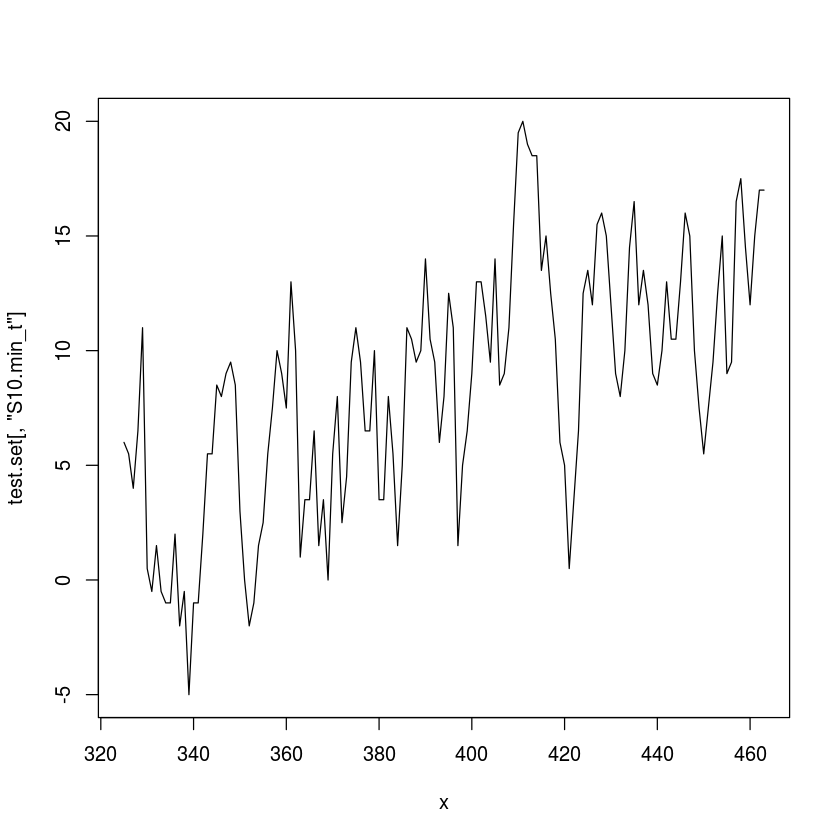

In [9]:
x = seq(from=325,to=(325+nrow(test.set)-1),by=1)
plot(x, test.set[,"S10.min_t"],type="l")

### Entrenando una Bayesian network con hill-climbing

Armando la blacklist: arcos que no serán incluidos en la red bayesiana. No nos interesa relacionar las variables _t entre sí, 
pues a priori sabemos que no contamos con dicha información

In [10]:
bl <- data.frame(from=character(),to=character(),stringsAsFactors=FALSE)
levels(bl$from) <- pred_sensores
levels(bl$to) <- pred_sensores
str(bl)
total <- length(pred_sensores)


'data.frame':	0 obs. of  2 variables:
 $ from: atomic  
  ..- attr(*, "levels")= chr  "S10.min_t" "S11.min_t" "S12.min_t" "S13.min_t" ...
 $ to  : atomic  
  ..- attr(*, "levels")= chr  "S10.min_t" "S11.min_t" "S12.min_t" "S13.min_t" ...


In [11]:

for(i in 1:total)
{
    bl1 = data.frame(from = rep(pred_sensores[i],total), to = pred_sensores)
    bl2 = data.frame(from = pred_sensores, to = rep(pred_sensores[i],total))
    bl = rbind.data.frame(bl,bl1,bl2)
}

print(bl)

         from        to
1   S10.min_t S10.min_t
2   S10.min_t S11.min_t
3   S10.min_t S12.min_t
4   S10.min_t S13.min_t
5   S10.min_t S14.min_t
6   S10.min_t S15.min_t
7   S10.min_t S16.min_t
8   S10.min_t S18.min_t
9   S10.min_t S19.min_t
10  S10.min_t  S1.min_t
11  S10.min_t S20.min_t
12  S10.min_t  S2.min_t
13  S10.min_t  S3.min_t
14  S10.min_t  S4.min_t
15  S10.min_t  S5.min_t
16  S10.min_t  S6.min_t
17  S10.min_t  S7.min_t
18  S10.min_t  S8.min_t
19  S10.min_t  S9.min_t
20  S10.min_t S10.min_t
21  S11.min_t S10.min_t
22  S12.min_t S10.min_t
23  S13.min_t S10.min_t
24  S14.min_t S10.min_t
25  S15.min_t S10.min_t
26  S16.min_t S10.min_t
27  S18.min_t S10.min_t
28  S19.min_t S10.min_t
29   S1.min_t S10.min_t
30  S20.min_t S10.min_t
31   S2.min_t S10.min_t
32   S3.min_t S10.min_t
33   S4.min_t S10.min_t
34   S5.min_t S10.min_t
35   S6.min_t S10.min_t
36   S7.min_t S10.min_t
37   S8.min_t S10.min_t
38   S9.min_t S10.min_t
39  S11.min_t S10.min_t
40  S11.min_t S11.min_t
41  S11.min_t S1

Armaremos una whitelist, lista de arcos que si o sí tiene que tener la red bayesiana.
Consideraremos arcos dirigidos desde las variables _T_1 y _T_2 hacia t  de un mismo sensor


In [12]:
wl <- data.frame(from=character(),to=character(),stringsAsFactors=FALSE)
#levels(bl$from) <- pred_sensores
#levels(bl$to) <- pred_sensores
str(wl)
total <- length(pred_sensores)

'data.frame':	0 obs. of  2 variables:
 $ from: chr 
 $ to  : chr 


In [13]:
s <- unlist(strsplit(pred_sensores,split=".",fixed = TRUE))
sensors <- s[grep("S",s)]
sensors

v <- colnames(training.set)

#vars_ejemplo <- v[grepl( sensors[1] , v)] # extraigo todas las variables relacionadas con sensor
#vars_ejemplo <- vars_ejemplo[-length(vars)] # quito la última variable min_t
#vars_ejemplo

sensor <- unlist(strsplit(pred_sensores[10],split=".",fixed = TRUE))[1]
sensor
sensor <- paste(sensor,".",sep="")
sensor
vars <- v[grepl( sensor, v, fixed = TRUE)] # extraigo todas las variables relacionadas con sensor
vars
vars <- vars[-length(vars)] # quito la última variable min_t
vars

[1] "S10" "S11" "S12" "S13" "S14" "S15" "S16" "S18" "S19" "S1"  "S20" "S2" 
[13] "S3"  "S4"  "S5"  "S6"  "S7"  "S8"  "S9"

[1] "S1"

[1] "S1."

[1] "S1.max_T_2"   "S1.media_T_2" "S1.min_T_2"   "S1.15hs_T_2"  "S1.12hs_T_2" 
 [6] "S1.18hs_T_2"  "S1.max_T_1"   "S1.media_T_1" "S1.min_T_1"   "S1.15hs_T_1" 
[11] "S1.12hs_T_1"  "S1.18hs_T_1"  "S1.min_t"

[1] "S1.max_T_2"   "S1.media_T_2" "S1.min_T_2"   "S1.15hs_T_2"  "S1.12hs_T_2" 
 [6] "S1.18hs_T_2"  "S1.max_T_1"   "S1.media_T_1" "S1.min_T_1"   "S1.15hs_T_1" 
[11] "S1.12hs_T_1"  "S1.18hs_T_1"

In [16]:

for(i in 1:total)
{
    sensor <- unlist(strsplit(pred_sensores[i],split=".",fixed = TRUE))[1]
    sensor <- paste(sensor,".",sep="")
    vars <- v[grepl( sensor, v, fixed = TRUE)] # extraigo todas las variables relacionadas con sensor
    vars <- vars[-length(vars)] # quito la última variable min_t

    wl1 = data.frame(from = vars, to = pred_sensores[i])
    wl = rbind.data.frame(wl,wl1)
}
print(wl)


             from        to
1     S10.max_T_2 S10.min_t
2   S10.media_T_2 S10.min_t
3     S10.min_T_2 S10.min_t
4    S10.15hs_T_2 S10.min_t
5    S10.12hs_T_2 S10.min_t
6    S10.18hs_T_2 S10.min_t
7     S10.max_T_1 S10.min_t
8   S10.media_T_1 S10.min_t
9     S10.min_T_1 S10.min_t
10   S10.15hs_T_1 S10.min_t
11   S10.12hs_T_1 S10.min_t
12   S10.18hs_T_1 S10.min_t
13    S11.max_T_2 S11.min_t
14  S11.media_T_2 S11.min_t
15    S11.min_T_2 S11.min_t
16   S11.15hs_T_2 S11.min_t
17   S11.12hs_T_2 S11.min_t
18   S11.18hs_T_2 S11.min_t
19    S11.max_T_1 S11.min_t
20  S11.media_T_1 S11.min_t
21    S11.min_T_1 S11.min_t
22   S11.15hs_T_1 S11.min_t
23   S11.12hs_T_1 S11.min_t
24   S11.18hs_T_1 S11.min_t
25    S12.max_T_2 S12.min_t
26  S12.media_T_2 S12.min_t
27    S12.min_T_2 S12.min_t
28   S12.15hs_T_2 S12.min_t
29   S12.12hs_T_2 S12.min_t
30   S12.18hs_T_2 S12.min_t
31    S12.max_T_1 S12.min_t
32  S12.media_T_1 S12.min_t
33    S12.min_T_1 S12.min_t
34   S12.15hs_T_1 S12.min_t
35   S12.12hs_T_1 S1

In [15]:
start_time <- Sys.time()
# learn BN structure on training set data , restart por defecto es 0
# modificar restart a 10 no hizo mucho efecto en los resultados de predicción
res = hc(training.set, whitelist=wl,blacklist = bl)
end_time <- Sys.time()
end_time - start_time

Mostramos la estructura de la red bayesiana creada con hc

In [16]:
res


  Bayesian network learned via Score-based methods

  model:
   [S12.max_T_1][S13.max_T_1|S12.max_T_1][S14.max_T_1|S12.max_T_1:S13.max_T_1]
   [S17.max_T_1|S12.max_T_1:S14.max_T_1][S14.15hs_T_1|S14.max_T_1]
   [S18.max_T_1|S13.max_T_1:S14.max_T_1:S17.max_T_1]
   [S2.max_T_1|S13.max_T_1:S17.max_T_1:S18.max_T_1]
   [S11.max_T_1|S13.max_T_1:S14.max_T_1:S2.max_T_1]
   [S15.max_T_1|S11.max_T_1:S12.max_T_1:S14.max_T_1:S17.max_T_1:S18.max_T_1]
   [S9.max_T_1|S11.max_T_1:S12.max_T_1:S15.max_T_1:S2.max_T_1:S14.15hs_T_1]
   [S19.max_T_1|S11.max_T_1:S12.max_T_1:S15.max_T_1:S9.max_T_1]
   [S4.max_T_1|S11.max_T_1:S12.max_T_1:S15.max_T_1:S17.max_T_1:S19.max_T_1:S2.max_T_1:S9.max_T_1]
   [S11.18hs_T_1|S19.max_T_1]
   [S6.max_T_1|S11.max_T_1:S15.max_T_1:S18.max_T_1:S2.max_T_1:S4.max_T_1:S9.max_T_1:S14.15hs_T_1]
   [S17.15hs_T_1|S14.max_T_1:S17.max_T_1:S19.max_T_1:S4.max_T_1:S14.15hs_T_1]
   [S10.max_T_1|S12.max_T_1:S17.max_T_1:S2.max_T_1:S6.max_T_1]
   [S7.max_T_1|S12.max_T_1:S13.max_T_1:S14.max_T_1:

Aprendizaje de parámetros 

In [17]:
start_time <- Sys.time()
fitted = bn.fit(res, training.set)     # learning of parameters
end_time <- Sys.time()
end_time - start_time

Time difference of 0.1943226 secs

Imprimimos los parámetros para los nodos que nos interesan predecir

In [18]:
fitted[pred_sensores]

$S10.min_t

  Parameters of node S10.min_t (Gaussian distribution)

Conditional density: S10.min_t | S10.max_T_2 + S10.media_T_2 + S2.media_T_2 + S10.min_T_2 + S10.15hs_T_2 + S10.12hs_T_2 + S10.18hs_T_2 + Est.humedad_med_T_2 + Est.temp_min_T_2 + S10.max_T_1 + S10.media_T_1 + S3.media_T_1 + S10.min_T_1 + S10.15hs_T_1 + S10.12hs_T_1 + S10.18hs_T_1 + S20.18hs_T_1
Coefficients:
        (Intercept)          S10.max_T_2        S10.media_T_2  
        -9.30256424          -0.01342298          -2.18785524  
       S2.media_T_2          S10.min_T_2         S10.15hs_T_2  
         2.04693362           0.07033331           0.02792178  
       S10.12hs_T_2         S10.18hs_T_2  Est.humedad_med_T_2  
         0.04512678          -0.12284425           0.04598495  
   Est.temp_min_T_2          S10.max_T_1        S10.media_T_1  
         0.24185197           0.25488694          -2.04556827  
       S3.media_T_1          S10.min_T_1         S10.15hs_T_1  
         2.69639834           0.25275199       

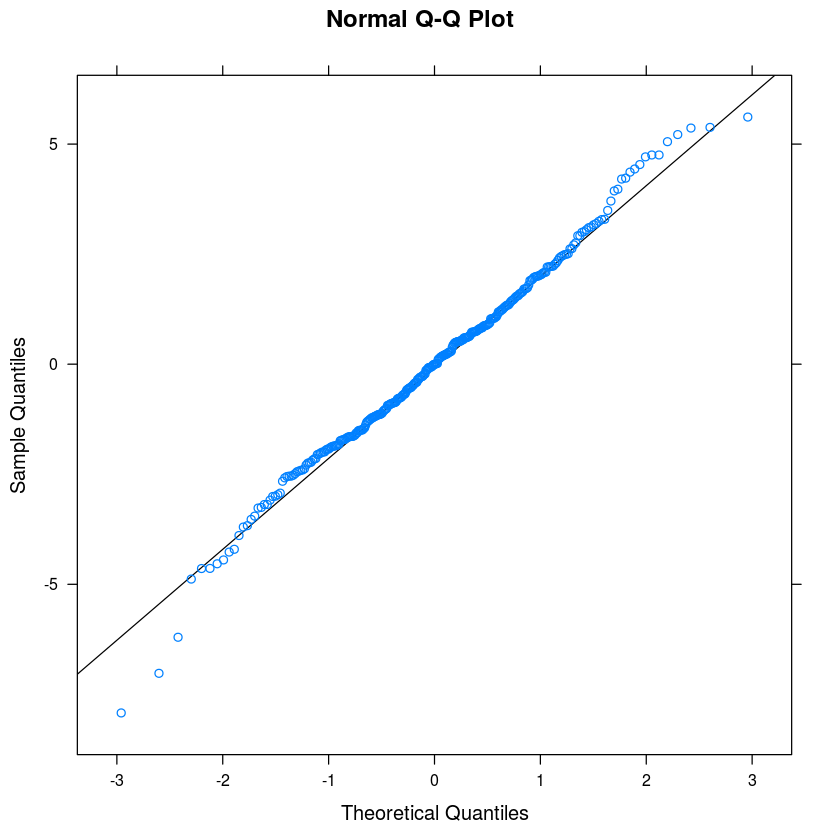

In [19]:
bn.fit.qqplot(fitted$S14.min_t)

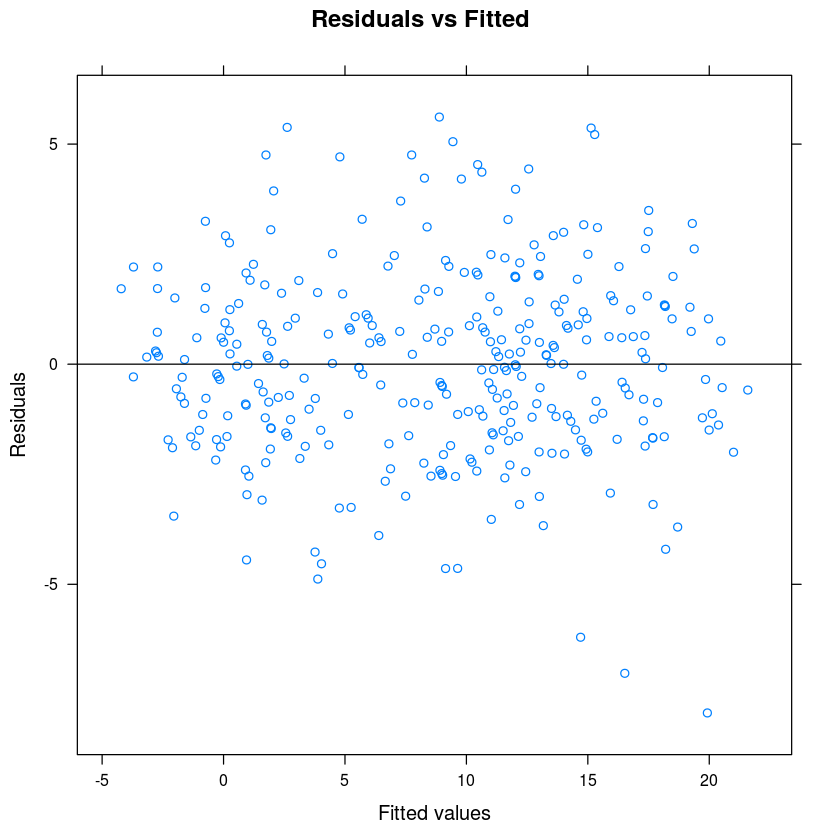

In [20]:
bn.fit.xyplot(fitted$S14.min_t) #pred_sensores

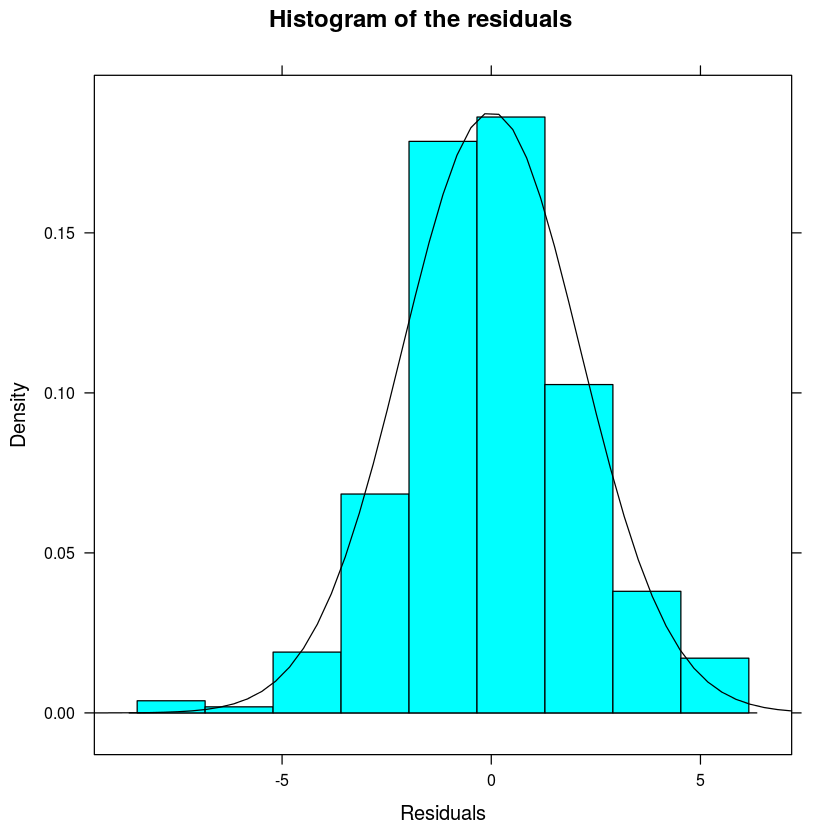

In [21]:
bn.fit.histogram(fitted$S14.min_t)

### Visualizando la matriz de adyacencia

In [22]:
#matriz de adyacencia
print(amat(res))

                    S10.max_T_2 S11.max_T_2 S12.max_T_2 S13.max_T_2 S14.max_T_2
S10.max_T_2                   0           0           1           0           0
S11.max_T_2                   0           0           0           1           0
S12.max_T_2                   0           0           0           1           0
S13.max_T_2                   0           0           0           0           1
S14.max_T_2                   0           0           0           0           0
S15.max_T_2                   0           1           1           0           1
S16.max_T_2                   0           0           0           0           0
S17.max_T_2                   0           0           0           0           0
S18.max_T_2                   0           0           0           0           1
S19.max_T_2                   0           1           1           0           0
S1.max_T_2                    0           0           0           0           0
S20.max_T_2                   0         

### Markov blanket 

In [23]:
for(i in 1:length(pred_sensores))
{
    cat("Markov blanket of ",pred_sensores[i],"\n")
    print(mb(res,pred_sensores[i]))
}

# pregunto por el markov blanket de S14.min
# mb(res,"S14.min_T")

Markov blanket of  S10.min_t 
 [1] "S10.max_T_2"         "S10.media_T_2"       "S2.media_T_2"       
 [4] "S10.min_T_2"         "S10.15hs_T_2"        "S10.12hs_T_2"       
 [7] "S10.18hs_T_2"        "Est.humedad_med_T_2" "Est.temp_min_T_2"   
[10] "S10.max_T_1"         "S10.media_T_1"       "S3.media_T_1"       
[13] "S10.min_T_1"         "S10.15hs_T_1"        "S10.12hs_T_1"       
[16] "S10.18hs_T_1"        "S20.18hs_T_1"       
Markov blanket of  S11.min_t 
 [1] "S11.max_T_2"         "S11.media_T_2"       "S2.media_T_2"       
 [4] "S5.media_T_2"        "S11.min_T_2"         "S11.15hs_T_2"       
 [7] "S15.15hs_T_2"        "S4.15hs_T_2"         "S7.15hs_T_2"        
[10] "S11.12hs_T_2"        "S11.18hs_T_2"        "Est.humedad_min_T_2"
[13] "S11.max_T_1"         "S19.max_T_1"         "S10.media_T_1"      
[16] "S11.media_T_1"       "S15.media_T_1"       "S20.media_T_1"      
[19] "S11.min_T_1"         "S12.min_T_1"         "S13.min_T_1"        
[22] "S14.min_T_1"         "S15.min_T_1

In [24]:
for(i in 1:length(pred_sensores))
{
    cat("Markov blanket of ",pred_sensores[i],"#nodes: ", length(mb(res,pred_sensores[i])),"\n")
}

Markov blanket of  S10.min_t #nodes:  17 
Markov blanket of  S11.min_t #nodes:  32 
Markov blanket of  S12.min_t #nodes:  45 
Markov blanket of  S13.min_t #nodes:  24 
Markov blanket of  S14.min_t #nodes:  16 
Markov blanket of  S15.min_t #nodes:  25 
Markov blanket of  S16.min_t #nodes:  20 
Markov blanket of  S18.min_t #nodes:  14 
Markov blanket of  S19.min_t #nodes:  16 
Markov blanket of  S1.min_t #nodes:  16 
Markov blanket of  S20.min_t #nodes:  16 
Markov blanket of  S2.min_t #nodes:  16 
Markov blanket of  S3.min_t #nodes:  21 
Markov blanket of  S4.min_t #nodes:  15 
Markov blanket of  S5.min_t #nodes:  25 
Markov blanket of  S6.min_t #nodes:  16 
Markov blanket of  S7.min_t #nodes:  16 
Markov blanket of  S8.min_t #nodes:  18 
Markov blanket of  S9.min_t #nodes:  16 


### Probrando predecir valores

### MiRAR ESTOS RESULTADOS, para cada una de las predicciones de los sensores.

In [25]:
df_res <- data.frame(Variable=character(),ME=double(),RMSE=double(),MAE=double(),MPE=double(),MAPE=double(),stringsAsFactors=FALSE)
levels(df_res$Variable) <- pred_sensores
str(df_res)
col <- c("Variable","ME","RMSE","MAE","MPE","MAPE")

'data.frame':	0 obs. of  6 variables:
 $ Variable: atomic  
  ..- attr(*, "levels")= chr  "S10.min_t" "S11.min_t" "S12.min_t" "S13.min_t" ...
 $ ME      : num 
 $ RMSE    : num 
 $ MAE     : num 
 $ MPE     : num 
 $ MAPE    : num 


- Realizamos la predicción para cada uno de los nodos sensores \_t usando los datos del test_set.
- Imprimimos para cada nodo \_t el valor real del dataset test_set (columna real) vs la predicción (columna pred)
- Luego se imprime una matriz de confusión teniendo en cuenta la variable my.breaks para discretizar la temperatura y formar las clases.



In [26]:
library(caret)
#llamar confusionMatrix de caret, pasar primero "a factor of predicted classes, then a factor
  # of classes to be used as the true results

breaks.binario <- c(-10,0,50) # caso Helada y no helada
my.breaks <- c(-10,-5,0,2,5,10,50) # rangos de temperatura a analizar

Loading required package: lattice
Loading required package: ggplot2


Imprimimos valor real vs predicción

In [27]:
for(i in 1:length(pred_sensores))
{
    cat("Testing on ",pred_sensores[i],"\n")
    # predicts the value of node pred_sensores[i]  given test set
    pred = predict(fitted, pred_sensores[i], test.set)  
    # compare the actual and predicted, then print the values
    aux <- accuracy(f = pred, x = test.set[,pred_sensores[i]])
    print(cbind(pred, real=test.set[, pred_sensores[i]]))
    
    r <- c(as.character(pred_sensores[i]),apply(aux,2,as.double))
    df_res <- rbind.data.frame(df_res,r,stringsAsFactors = FALSE) 
}

colnames(df_res) <- col

Testing on  S10.min_t 
               pred real
  [1,]  3.009814697  6.0
  [2,]  5.397536906  5.5
  [3,]  5.349293677  4.0
  [4,]  4.526581976  6.5
  [5,]  7.391169204 11.0
  [6,]  6.194031441  0.5
  [7,]  0.366671357 -0.5
  [8,]  0.760465811  1.5
  [9,] -0.024015479 -0.5
 [10,] -0.993910060 -1.0
 [11,] -0.500790290 -1.0
 [12,] -0.325193874  2.0
 [13,]  0.562567745 -2.0
 [14,]  0.044166994 -0.5
 [15,] -0.706612899 -5.0
 [16,] -2.175431070 -1.0
 [17,] -0.872105302 -1.0
 [18,]  1.373929859  2.0
 [19,]  3.262605594  5.5
 [20,]  6.478778143  5.5
 [21,]  6.654354490  8.5
 [22,]  9.236842062  8.0
 [23,]  8.084282061  9.0
 [24,]  7.956887359  9.5
 [25,]  6.035467133  8.5
 [26,]  3.644745121  3.0
 [27,]  0.874376960  0.0
 [28,]  0.003110212 -2.0
 [29,] -0.769504976 -1.0
 [30,]  0.132104771  1.5
 [31,]  1.995366195  2.5
 [32,]  3.847343835  5.5
 [33,]  6.974333596  7.5
 [34,]  7.532166892 10.0
 [35,] 10.074833513  9.0
 [36,]  7.798730565  7.5
 [37,]  6.425262367 13.0
 [38,]  8.981778601 10.0
 [

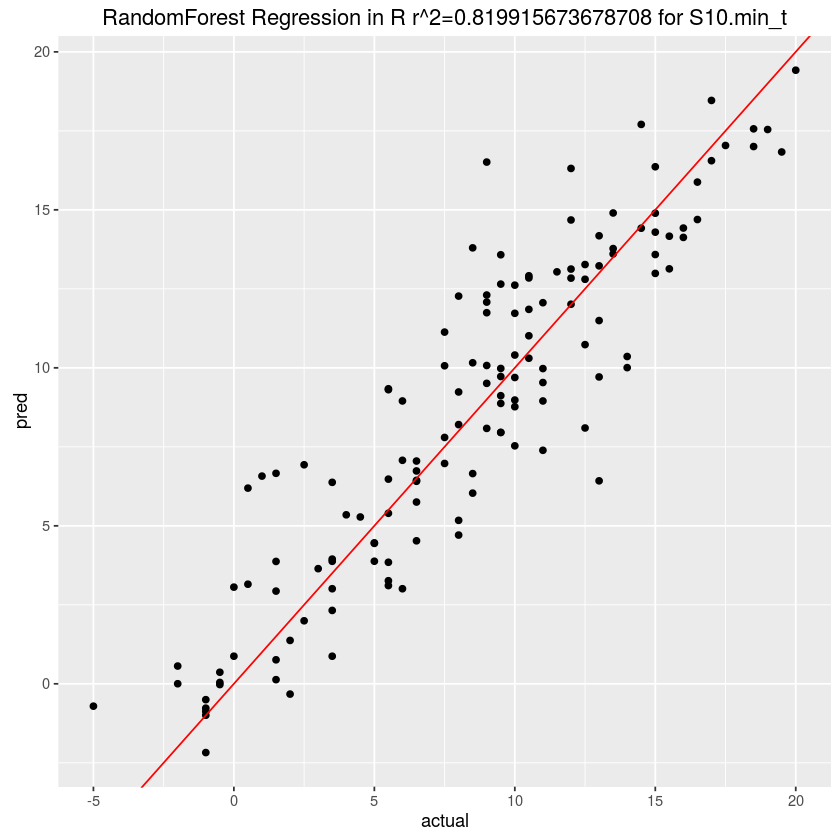

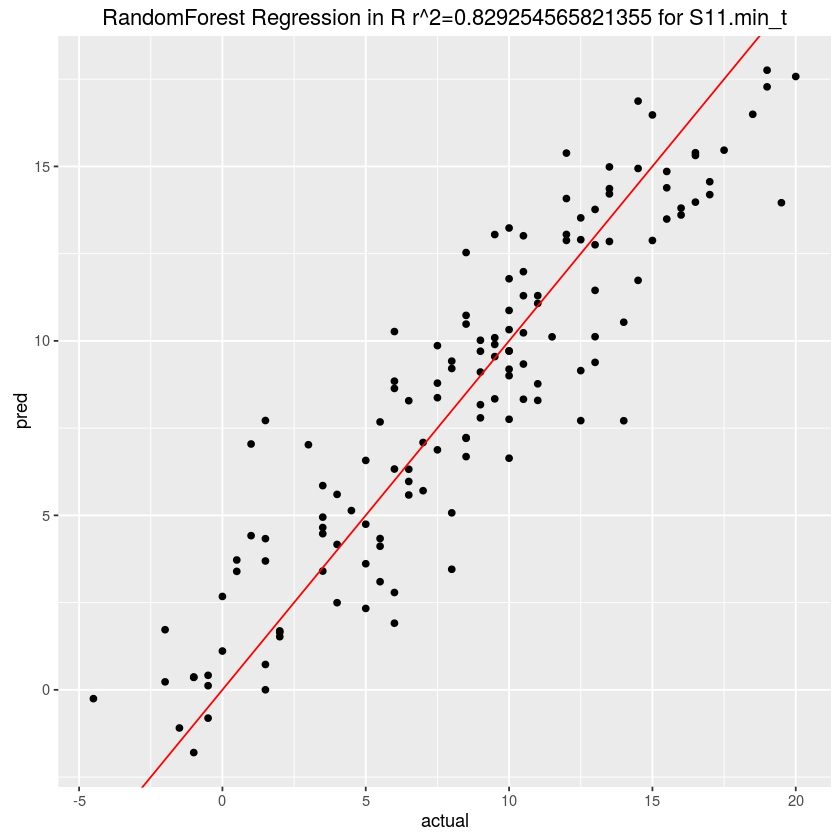

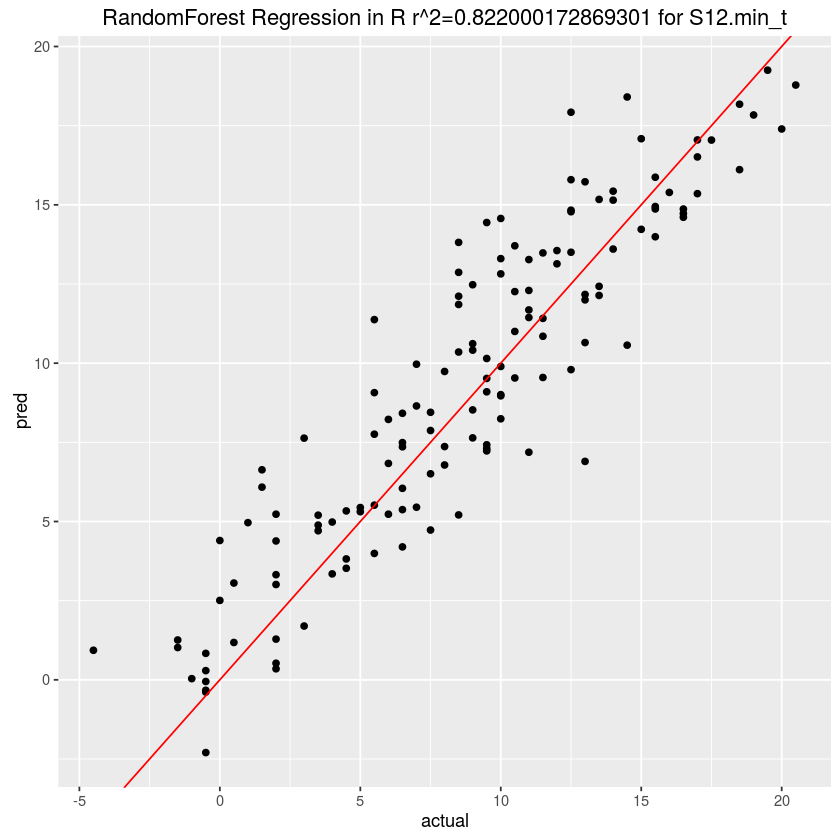

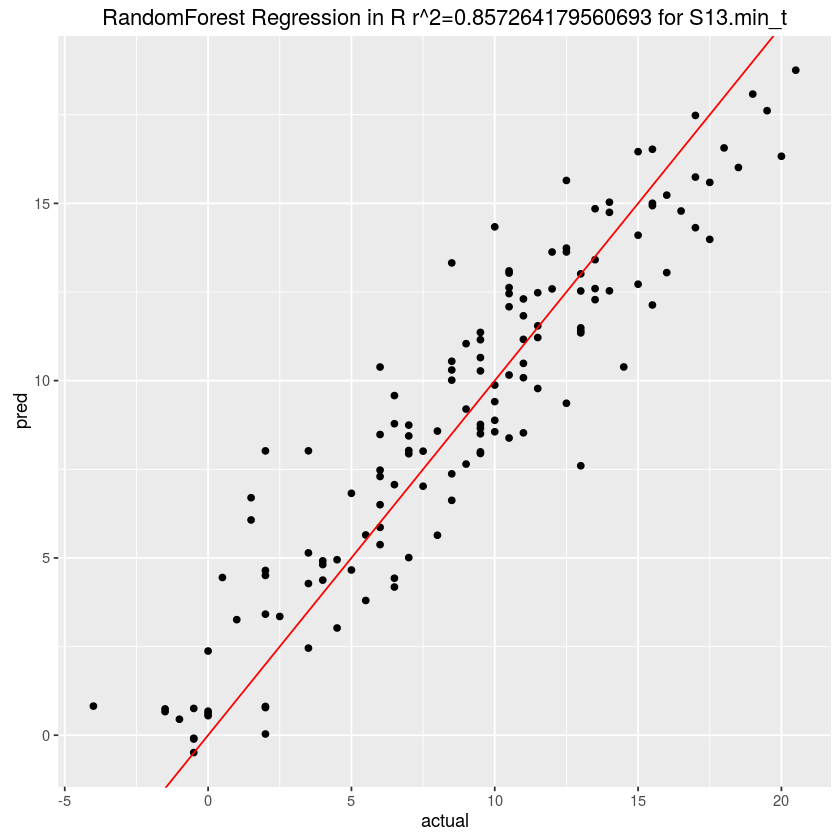

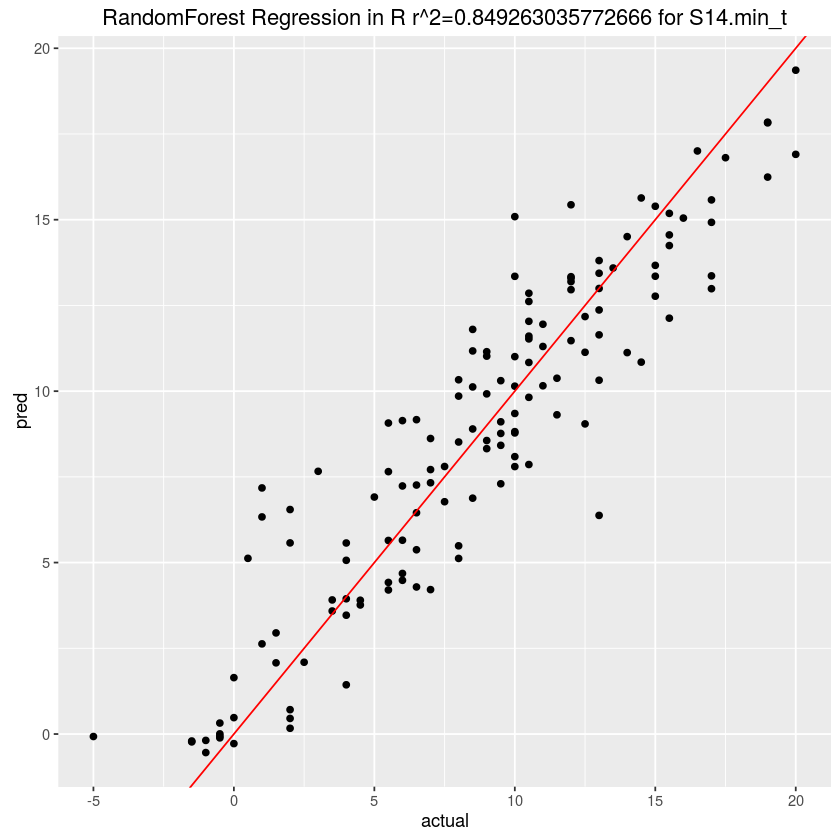

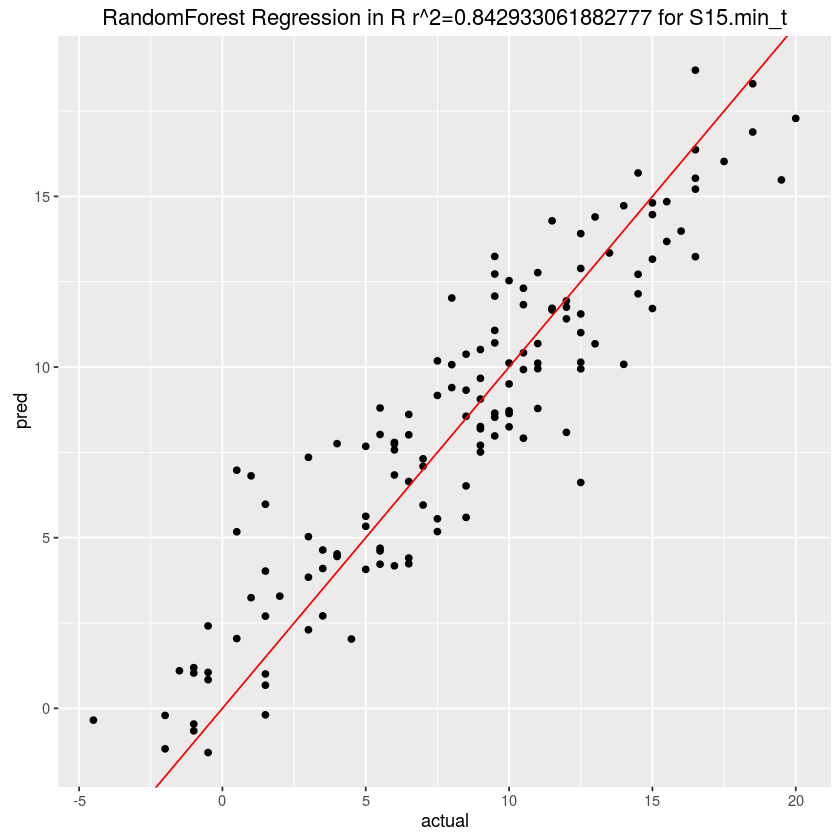

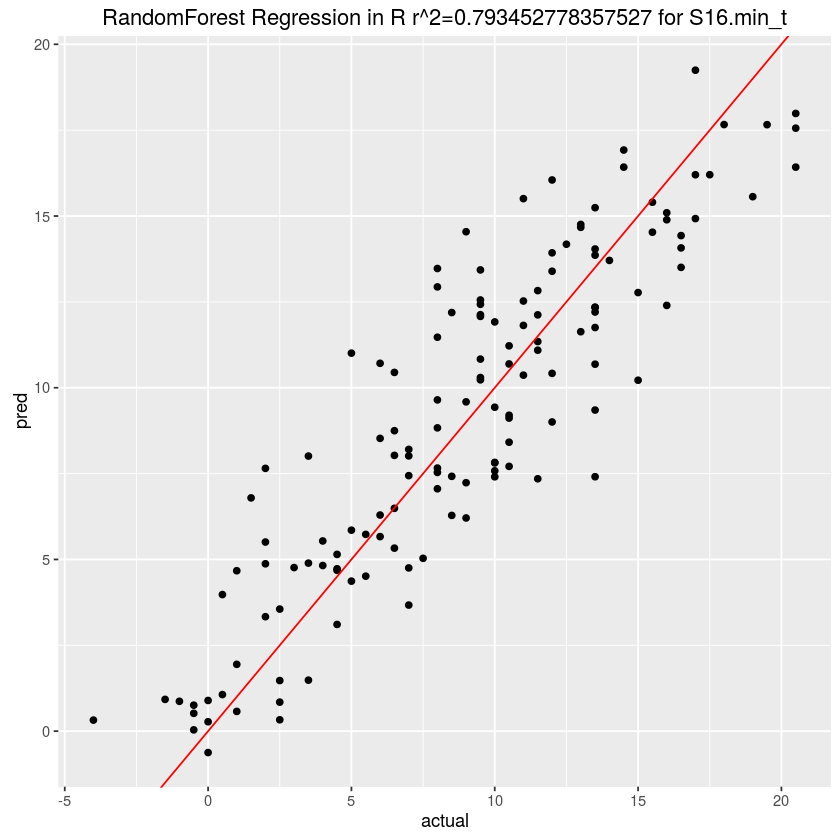

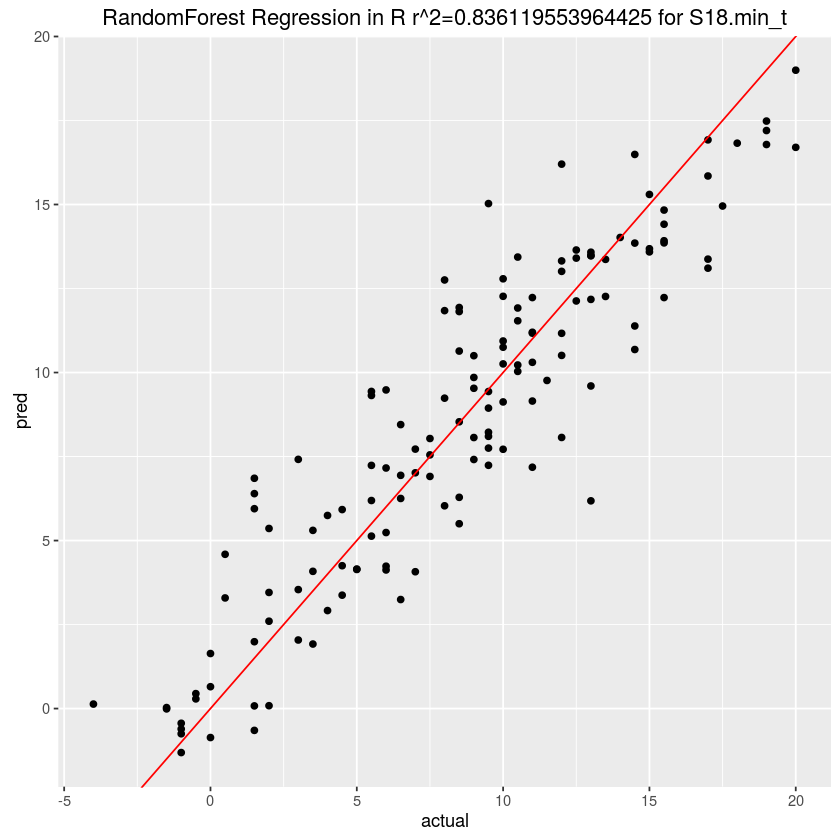

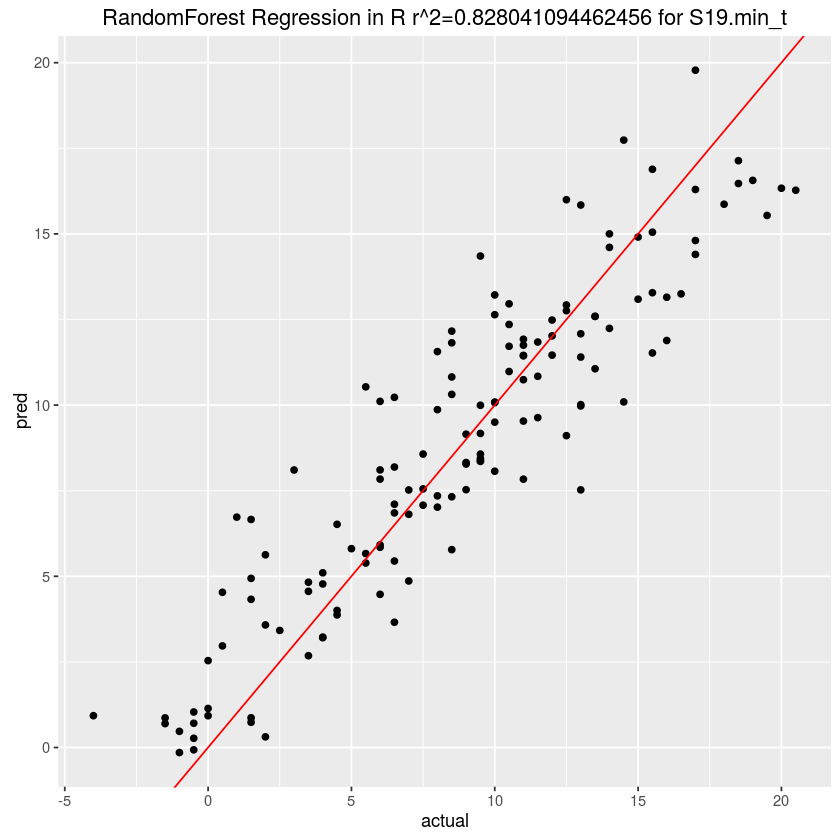

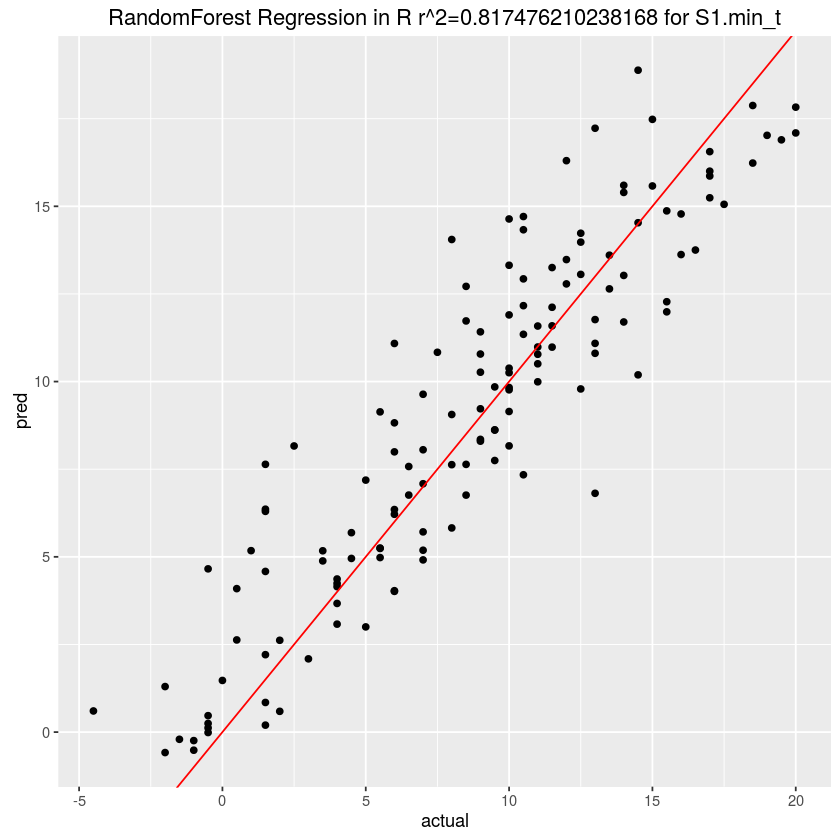

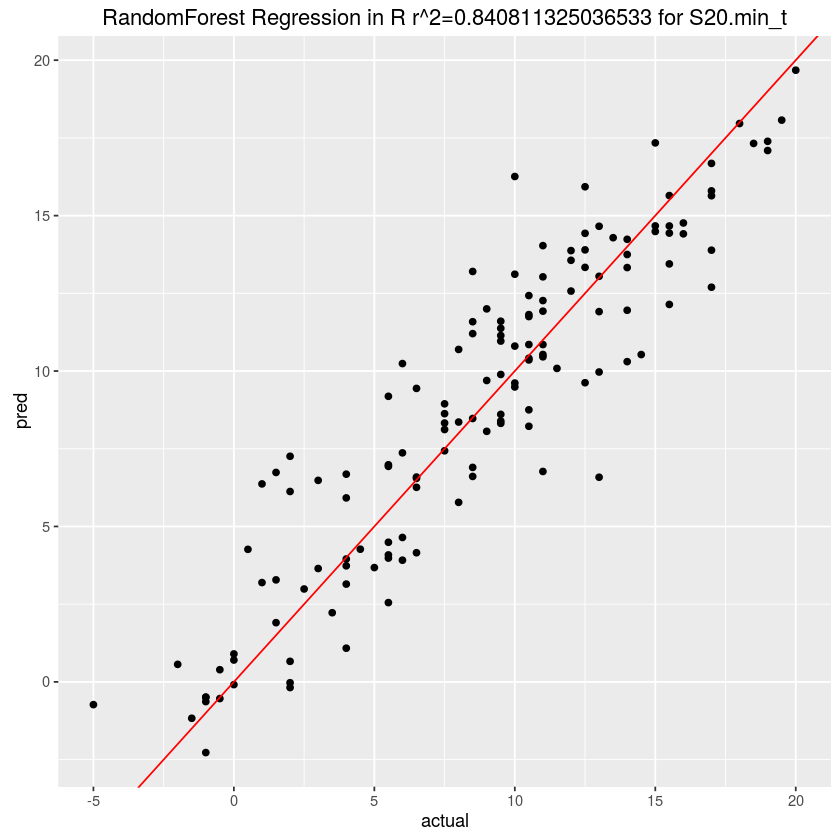

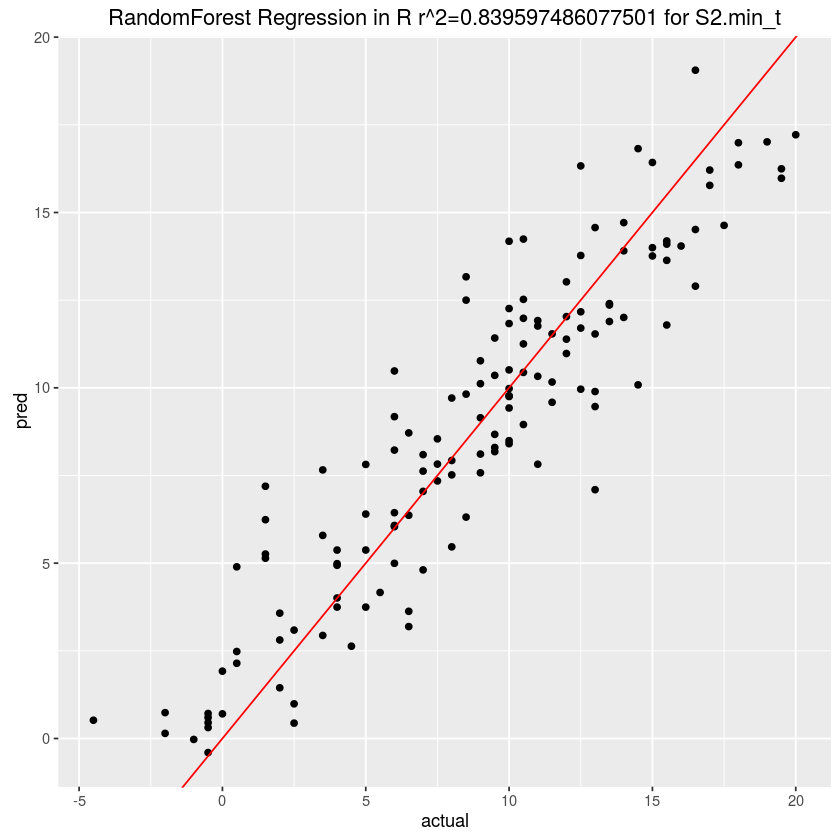

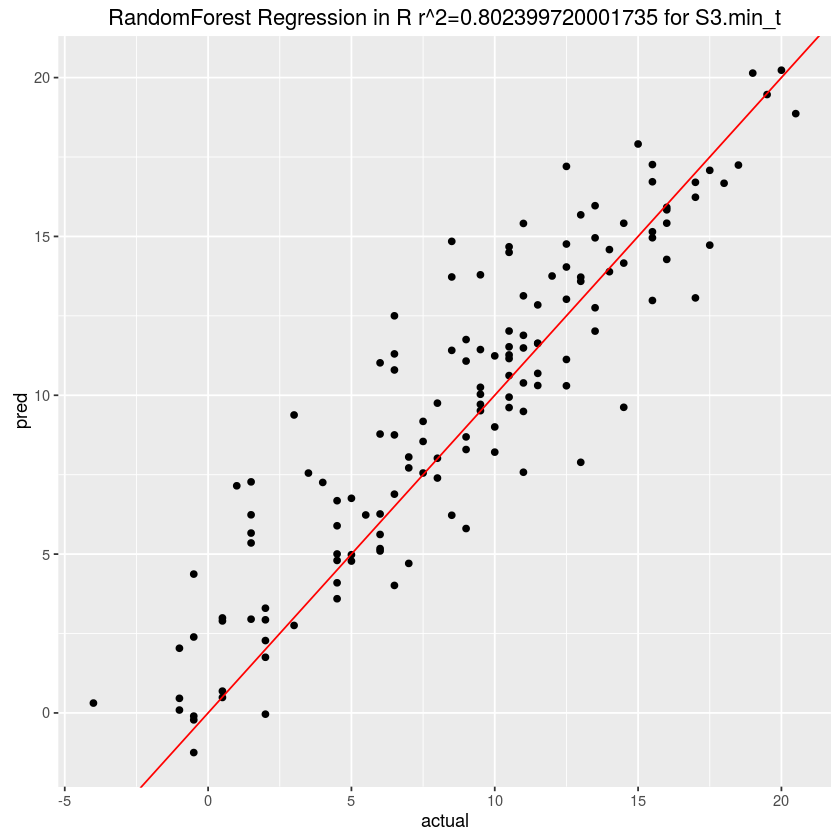

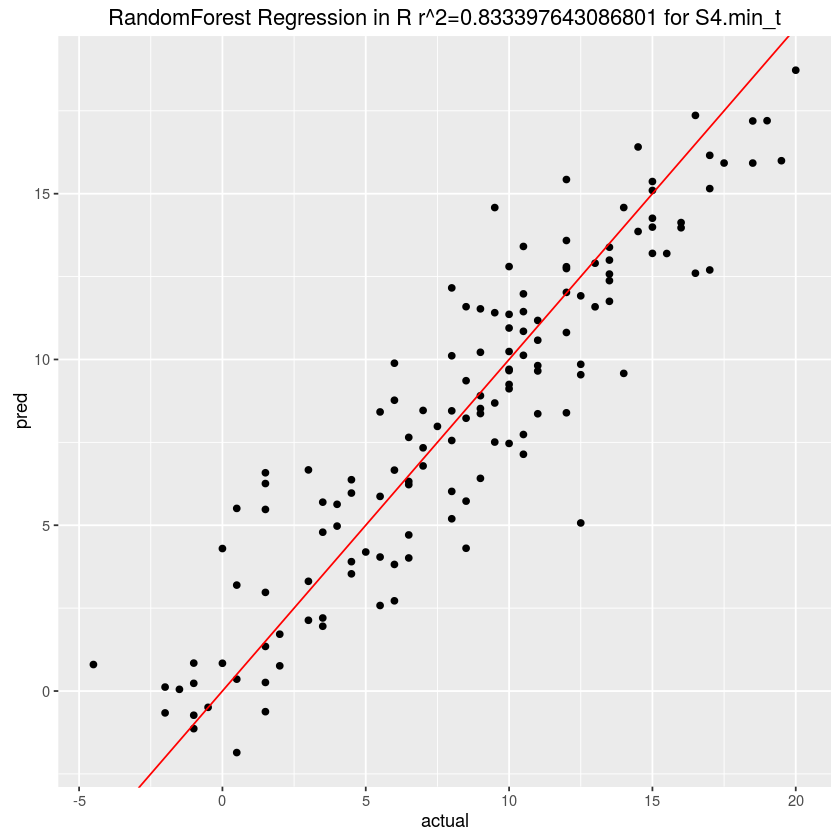

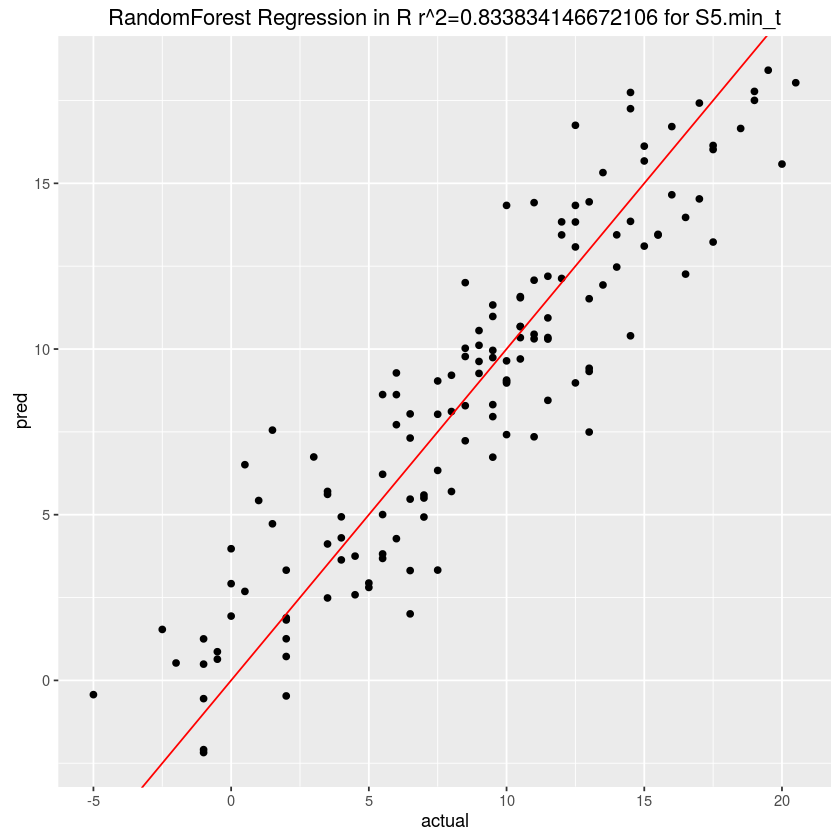

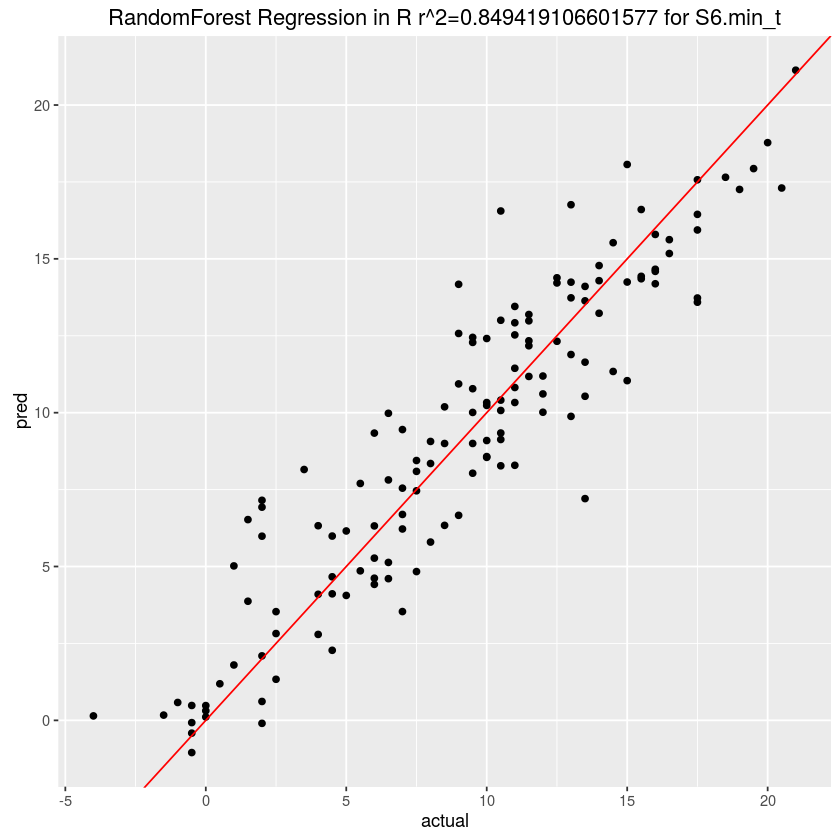

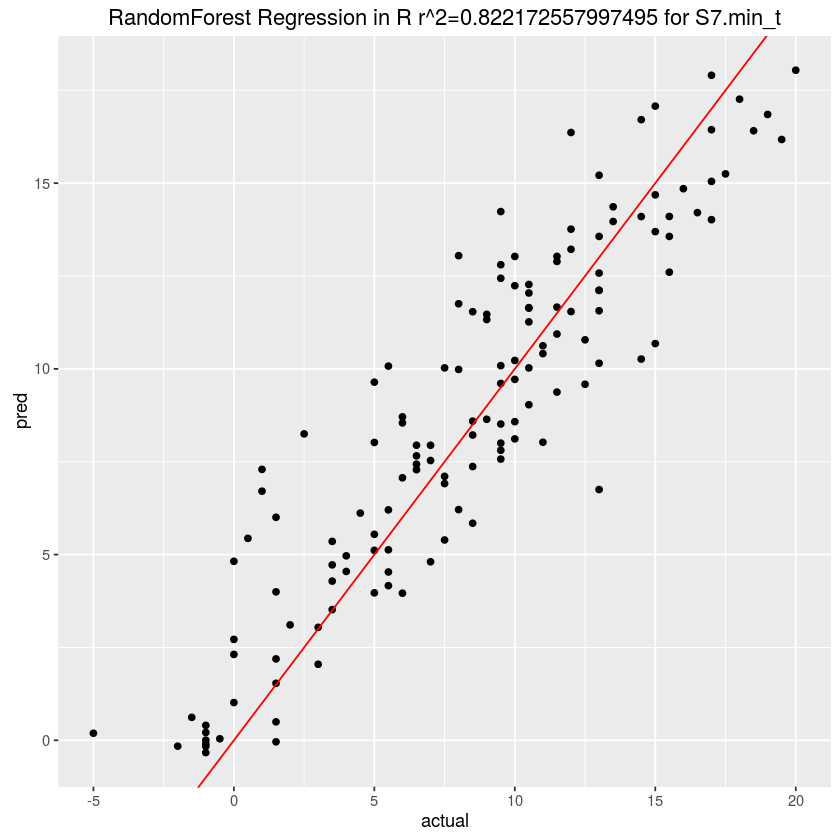

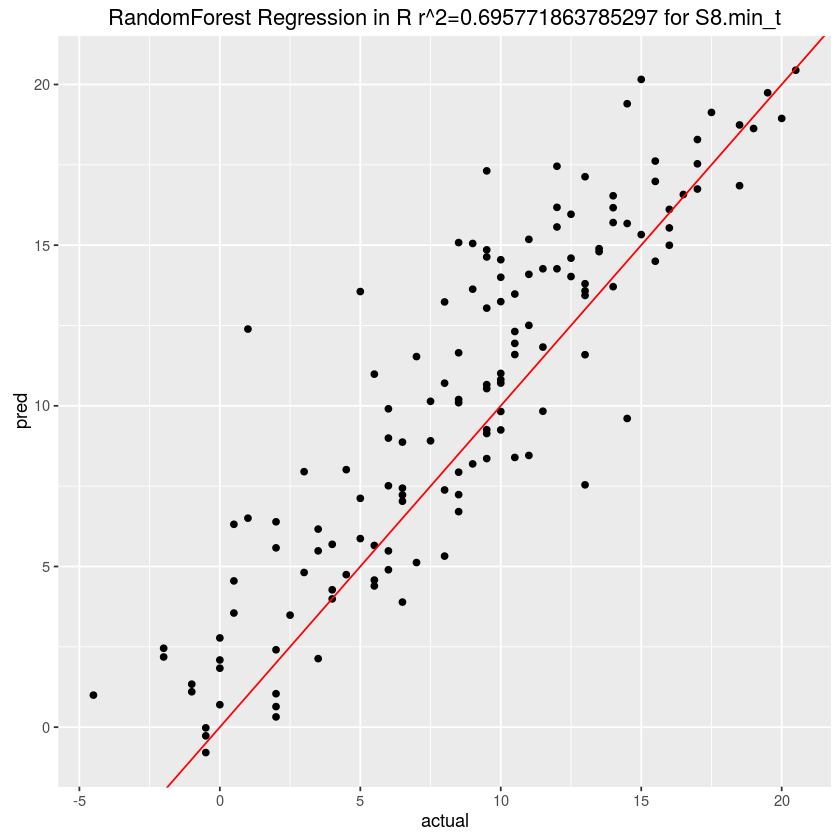

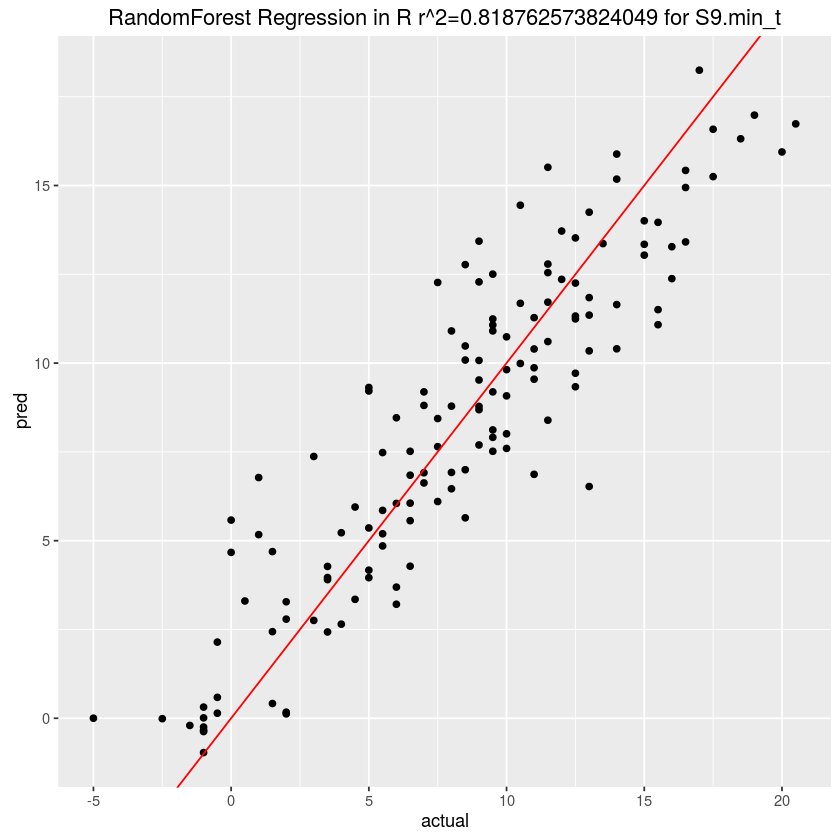

In [39]:
library(miscTools)
library(ggplot2)

for(i in 1:length(pred_sensores))
{
    # predicts the value of node pred_sensores[i]  given test set
    pred = predict(fitted, pred_sensores[i], test.set) 
  
    #' Plot R_2, valores predichos vs valores reales
    #' 
    (r2 <- rSquared(test.set[,pred_sensores[i]], test.set[,pred_sensores[i]] - pred))

    p <- ggplot(aes(x=actual, y=pred),
                data=data.frame(actual=test.set[,pred_sensores[i]], pred=pred))
    pp <- p + geom_point() +
      geom_abline(color="red") +
      ggtitle(paste("RandomForest Regression in R r^2=", r2," for ",pred_sensores[i], sep=""))
    
    plot(pp)
}

Imprimimos matriz de confusion caso binario (helada (temperaturas menores a cero) y no helada

In [103]:
for(i in 1:length(pred_sensores))
{
    cat("Confusion matrix helada/no helada",pred_sensores[i],"\n")
    pred = predict(fitted, pred_sensores[i], test.set)
    y <- cut(test.set[, pred_sensores[i]], breaks = breaks.binario)
    y_pred <- cut(pred, breaks = breaks.binario)
    print(confusionMatrix(y_pred,y))
}


Confusion matrix helada/no helada S10.min_t 
Confusion Matrix and Statistics

          Reference
Prediction (-10,0] (0,50]
   (-10,0]       7      1
   (0,50]        6    125
                                         
               Accuracy : 0.9496         
                 95% CI : (0.899, 0.9795)
    No Information Rate : 0.9065         
    P-Value [Acc > NIR] : 0.04614        
                                         
                  Kappa : 0.6411         
 Mcnemar's Test P-Value : 0.13057        
                                         
            Sensitivity : 0.53846        
            Specificity : 0.99206        
         Pos Pred Value : 0.87500        
         Neg Pred Value : 0.95420        
             Prevalence : 0.09353        
         Detection Rate : 0.05036        
   Detection Prevalence : 0.05755        
      Balanced Accuracy : 0.76526        
                                         
       'Positive' Class : (-10,0]        
                          

Imprimimos matriz de confusión considerando otro rango de temperaturas

In [104]:
for(i in 1:length(pred_sensores))
{

    cat("Confusion matrix ",pred_sensores[i],"\n")    
    pred = predict(fitted, pred_sensores[i], test.set)
    y <- cut(test.set[, pred_sensores[i]], breaks = my.breaks)
    y_pred <- cut(pred, breaks = my.breaks)
    print(confusionMatrix(y_pred,y))
 
}


Confusion matrix  S10.min_t 
Confusion Matrix and Statistics

          Reference
Prediction (-10,-5] (-5,0] (0,2] (2,5] (5,10] (10,50]
  (-10,-5]        0      0     0     0      0       0
  (-5,0]          1      6     1     0      0       0
  (0,2]           0      5     3     2      0       0
  (2,5]           0      1     3     8      6       0
  (5,10]          0      0     3     4     30       7
  (10,50]         0      0     0     0     15      44

Overall Statistics
                                          
               Accuracy : 0.6547          
                 95% CI : (0.5694, 0.7332)
    No Information Rate : 0.3669          
    P-Value [Acc > NIR] : 5.715e-12       
                                          
                  Kappa : 0.5101          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: (-10,-5] Class: (-5,0] Class: (0,2] Class: (2,5]
Sensitivity                 0.000000       0.50000      0.30000      0.57143


* ME: Mean Error
* RMSE: Root Mean Squared Error
* MAE: Mean Absolute Error
* MPE: Mean Percentage Error
* MAPE: Mean Absolute Percentage Error


In [105]:
colnames(df_res)

[1] "Variable" "ME"       "RMSE"     "MAE"      "MPE"      "MAPE"

In [106]:
# TODO redondear a dos decimales
#df_res[,2:4] <-round(df_res[,2:4],2) #the "-1" excludes column 1
df_res[,1:4]

Variable  ME                  RMSE             MAE             
1  S10.min_t -0.284129387282876  2.29030262546606 1.75023834940856
2  S11.min_t 0.00386687177940955 2.22893124638162 1.78383622654304
3  S12.min_t -0.589297637556412  2.29449216200282 1.82827624623666
4  S13.min_t -0.243050914513732  2.0375634967805  1.63297536139526
5  S14.min_t -0.084447782698958  2.07765040824201 1.60431809415632
6  S15.min_t -0.203129568338425  2.10030269632462 1.68278064708235
7  S16.min_t -0.26333882043866   2.42728912664983 1.96168438020429
8  S18.min_t -0.0616609006300067 2.18609165646555 1.70196435910733
9  S19.min_t -0.192483767580192  2.25833859990453 1.78133593142541
10 S1.min_t  -0.491128984434115  2.35026821619986 1.81267435131667
11 S20.min_t -0.224474474943172  2.16630024727224 1.66898201948685
12 S2.min_t  -0.128355282438334  2.14903148225432 1.70568344588952
13 S3.min_t  -0.842754867349005  2.41036901703138 1.78089724693936
14 S4.min_t  0.101842384735475   2.20536721835658 1.718011875921  
15 S5.min_t  0.0202193058544826  2.26390632211176 1.84119079021103
16 S6.min_t  -0.154730472204408  2.11359008476926 1.63334810424716
17 S7.min_t  -0.434805913030238  2.29103491089237 1.80193063828315
18 S8.min_t  -1.57983687885474   3.00265503440952 2.27573795968988
19 S9.min_t  -0.0618293392208603 2.28172583245735 1.81448692172635
20 S10.min_t -0.284129387282876  2.29030262546606 1.75023834940856
21 S11.min_t 0.00386687177940955 2.22893124638162 1.78383622654304
22 S12.min_t -0.589297637556412  2.29449216200282 1.82827624623666
23 S13.min_t -0.243050914513732  2.0375634967805  1.63297536139526
24 S14.min_t -0.084447782698958  2.07765040824201 1.60431809415632
25 S15.min_t -0.203129568338425  2.10030269632462 1.68278064708235
26 S16.min_t -0.26333882043866   2.42728912664983 1.96168438020429
27 S18.min_t -0.0616609006300067 2.18609165646555 1.70196435910733
28 S19.min_t -0.192483767580192  2.25833859990453 1.78133593142541
29 S1.min_t  -0.491128984434115  2.35026821619986 1.81267435131667
30 S20.min_t -0.224474474943172  2.16630024727224 1.66898201948685
31 S2.min_t  -0.128355282438334  2.14903148225432 1.70568344588952
32 S3.min_t  -0.842754867349005  2.41036901703138 1.78089724693936
33 S4.min_t  0.101842384735475   2.20536721835658 1.718011875921  
34 S5.min_t  0.0202193058544826  2.26390632211176 1.84119079021103
35 S6.min_t  -0.154730472204408  2.11359008476926 1.63334810424716
36 S7.min_t  -0.434805913030238  2.29103491089237 1.80193063828315
37 S8.min_t  -1.57983687885474   3.00265503440952 2.27573795968988
38 S9.min_t  -0.0618293392208603 2.28172583245735 1.81448692172635

#### Conclusiones


Las predicciones de las variables *\_t presentan un RSME entre 2 y 3. 

Al ver las confusion matrix vemos que falla en la predicción de heladas en general la mitad de las veces. Pero en vez de predecir un valor bajo cero, predice un valor entre 0 y 5 grados.

No hay una correlación con el tamaño del Markov blanket y la precisión de la predicción.

En general los resultados son buenos considerando:

- el gran número de variables o nodos (271) vs el tamaño del dataset (463 datapoints o filas) 
- no se aplicó tuneo el algoritmo, se usó sus parámetros por defecto. Aunque para modelar el problema de forma realista se pasaron lista de arcos a incluir (whitelist) y aquellos que no se deben incluir (blacklist)
- se tienen poco casos del fenómeno de heladas tanto en el conjunto de entrenamiento como testeo. 






In [33]:
# nro de heladas en training set
length(training.set[which(training.set$S20.min_t<=0),"S20.min_t"])

[1] 49

In [34]:
# nro de heladas en testset
length(test.set[which(test.set$S20.min_t<=0),"S20.min_t"]) 

[1] 12

#### TODO list
- plot de la red bayesiana. Dado que son muchas variables, se hace muy denso el plot, por lo que es conveniente encontrar herramientas para generar plots dinámicos, que permitan hacer zoom, mover los nodos, por ejemplo
- realizar queries sobre la red bayesiana, por ejemplo, dado ciertos valores de algunas variables, cuan probable es que otras variables tomen ciertos valores
- nota mental: ¿Cómo podríamos generar nuevos casos artificialmente?

### Intento con oversampling, generando artificialmente nuevos casos de heladas.

In [16]:
df[which(df$S20.min_t <=0),pred_sensores]

S10.min_t S11.min_t S12.min_t S13.min_t S14.min_t S15.min_t S16.min_t
8   -0.5      -1.0      -0.5      -0.5      -0.5      -1.0       0.0     
9   -4.0      -4.5      -4.0      -4.0      -4.0      -4.5      -4.0     
10  -3.0      -3.0      -2.5      -2.5      -2.5      -3.0      -2.5     
11  -1.5      -1.5      -1.5      -1.0      -1.5      -1.5      -1.0     
13  -0.5      -0.5       0.0       0.5      -0.5      -0.5       0.5     
14  -3.0      -3.0      -2.5      -2.5      -3.0      -3.0      -2.5     
16  -2.0      -2.5      -2.0      -2.0      -2.0      -2.5      -2.0     
17  -0.5      -1.0      -0.5       0.0      -0.5      -0.5       0.0     
21  -3.5      -3.5      -3.5      -3.5      -3.5      -4.0      -3.0     
217 -1.5      -1.0      -1.0      -0.5      -1.0      -1.0      -1.5     
258 -0.5      -0.5      -0.5      -0.5      -0.5      -1.0       0.0     
259  0.0       0.0       0.5       0.5       0.5       0.0       0.5     
260  0.0       0.0       0.0       1.0       0.5       0.0       0.5     
261  0.0       0.0       0.5       1.0       0.5       0.0       1.0     
262 -0.5      -0.5       0.0       0.0       0.0      -0.5       0.5     
271 -0.5      -0.5      -0.5       0.0      -0.5      -0.5       0.0     
272 -2.5      -2.5      -2.0      -2.0      -2.0      -2.5      -1.5     
273 -2.0      -2.0      -2.0      -2.0      -2.0      -2.5      -1.5     
274 -0.5      -0.5       0.0       0.0       0.0      -0.5       0.5     
276 -0.5      -1.0      -0.5      -0.5      -0.5      -0.5       0.0     
277  0.0       0.0       1.0       0.5       0.5       0.0       1.5     
278 -2.0      -2.0      -1.5      -1.5      -2.0      -2.0      -1.5     
279 -3.0      -3.0      -2.5      -2.5      -3.0      -3.0      -2.0     
280 -2.5      -2.5      -2.0      -2.0      -2.5      -2.5      -2.0     
284 -1.5      -1.5      -1.0      -1.0      -1.5      -1.5      -0.5     
285 -1.0      -1.0      -1.0      -1.0      -1.0      -1.5      -0.5     
286 -1.0      -0.5       0.0       0.0      -0.5      -0.5       0.0     
292 -0.5      -0.5      -0.5      -0.5      -0.5      -1.0       0.0     
293 -2.0      -2.0      -2.0      -2.0      -2.0      -3.0      -1.5     
294 -2.5      -2.5      -2.0      -2.0      -2.0      -2.5      -1.5     
⋮   ⋮         ⋮         ⋮         ⋮         ⋮         ⋮         ⋮        
296 -1.5      -1.5      -1.0      -1.0      -1.0      -1.5      -1.0     
297 -2.0      -2.0      -1.5      -1.5      -1.5      -2.0      -1.0     
298 -3.0      -3.0      -2.5      -2.0      -2.5      -3.0      -2.0     
299 -3.0      -3.0      -2.5      -2.5      -2.5      -3.0      -2.0     
300 -3.0      -3.0      -2.5      -2.5      -2.5      -3.0      -2.0     
301 -6.0      -6.0      -5.0      -5.0      -5.5      -6.0      -5.0     
302 -3.5      -3.5      -3.5      -3.0      -3.0      -3.5      -3.0     
304 -2.5      -2.5      -1.0      -1.0      -1.5      -2.0      -1.0     
305 -1.5      -2.0      -1.0      -1.5      -1.5      -2.0      -1.0     
306 -1.0      -1.0      -1.0      -1.0      -1.5      -1.5      -0.5     
308  0.0      -0.5       0.0       0.0       0.0      -0.5       0.5     
310 -1.0      -0.5       0.0       0.0      -0.5      -1.0       0.0     
318 -2.5      -2.0      -2.0      -1.5      -1.5      -2.0      -1.5     
319 -4.5      -4.5      -4.0      -4.0      -4.0      -4.5      -4.0     
320 -4.5      -4.5      -4.0      -4.0      -4.0      -4.5      -4.0     
321 -3.0      -2.5      -2.5      -2.0      -2.5      -2.5      -1.0     
322 -2.5      -2.5      -2.5      -2.5      -2.5      -3.0      -2.0     
323 -3.0      -3.0      -2.0      -2.5      -2.5      -3.0      -2.0     
331 -0.5       0.0       0.5       0.0       0.0      -0.5       0.5     
333 -0.5      -0.5      -0.5       0.0      -0.5      -0.5       0.0     
334 -1.0      -1.0      -0.5      -0.5      -0.5      -1.0       0.0     
335 -1.0      -1.0      -0.5      -0.5      -1.0      -1.0      -0.5     
337 -2.0

In [17]:
#dias de datos con heladas
nrow(df[which(df$S20.min_t <=0),pred_sensores])

[1] 61

In [18]:
#genero etiquetas: 1 noche de helada y 0 no helada

Y_class <- as.factor(with(df,ifelse(S20.min_t <= 0,1,0)))

In [19]:
length(Y_class) # control

[1] 463

In [20]:
which(Y_class == 1) # control

[1]   8   9  10  11  13  14  16  17  21 217 258 259 260 261 262 271 272 273 274
[20] 276 277 278 279 280 284 285 286 292 293 294 295 296 297 298 299 300 301 302
[39] 304 305 306 308 310 318 319 320 321 322 323 331 333 334 335 337 338 339 340
[58] 341 351 352 353

In [21]:
which(df$S20.min_t <= 0) # control

[1]   8   9  10  11  13  14  16  17  21 217 258 259 260 261 262 271 272 273 274
[20] 276 277 278 279 280 284 285 286 292 293 294 295 296 297 298 299 300 301 302
[39] 304 305 306 308 310 318 319 320 321 322 323 331 333 334 335 337 338 339 340
[58] 341 351 352 353

In [22]:
library(unbalanced)

Loading required package: mlr
Loading required package: ParamHelpers
Warning message:
“replacing previous import ‘BBmisc::isFALSE’ by ‘backports::isFALSE’ when loading ‘mlr’”Loading required package: foreach
Loading required package: doParallel
Loading required package: iterators
Loading required package: parallel


Genera nuevos samples de la clase minoritaria usando el método SMOTE (synthetic minority over-sampling technique)

Para más detalles ver:

Chawla, Nitesh V., et al. "SMOTE: synthetic minority over-sampling technique." arXiv preprint arXiv:1106.1813 (2011).


In [23]:
dataset <- ubBalance(df,Y_class,type = "ubSMOTE",percOver = 300, percUnder = 150)

In [35]:
dataset$index.rm

NULL

In [31]:
df[123.1,]

S10.max_T_2 S11.max_T_2 S12.max_T_2 S13.max_T_2 S14.max_T_2 S15.max_T_2
123 34.5        35          35.5        35          35          37         
    S16.max_T_2 S17.max_T_2 S18.max_T_2 S19.max_T_2 ⋯ S1.min_t S20.min_t
123 36          34          34.5        39          ⋯ 16       16       
    S2.min_t S3.min_t S4.min_t S5.min_t S6.min_t S7.min_t S8.min_t S9.min_t
123 16       16.5     16       16       16.5     15.5     15.5     15

In [48]:
nrow(dataset$X)

[1] 518

In [96]:
dataset$X[!complete.cases(dataset$X),] # chequeando nulls or NaN

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”

S10.max_T_2 S11.max_T_2 S12.max_T_2 S13.max_T_2 S14.max_T_2 S15.max_T_2
     S16.max_T_2 S17.max_T_2 S18.max_T_2 S19.max_T_2 ⋯ S1.min_t S20.min_t
     S2.min_t S3.min_t S4.min_t S5.min_t S6.min_t S7.min_t S8.min_t S9.min_t

In [49]:
summary(dataset$Y) # distribucion de las clases

0   1 
274 244

In [50]:
summary(dataset$X)

  S10.max_T_2     S11.max_T_2     S12.max_T_2     S13.max_T_2   
 Min.   : 7.00   Min.   : 7.00   Min.   : 7.00   Min.   : 7.00  
 1st Qu.:18.00   1st Qu.:17.25   1st Qu.:17.80   1st Qu.:17.75  
 Median :22.00   Median :21.17   Median :22.00   Median :21.79  
 Mean   :23.68   Mean   :23.01   Mean   :23.71   Mean   :23.58  
 3rd Qu.:29.88   3rd Qu.:29.00   3rd Qu.:29.50   3rd Qu.:29.50  
 Max.   :42.50   Max.   :40.50   Max.   :42.00   Max.   :41.50  
  S14.max_T_2     S15.max_T_2     S16.max_T_2     S17.max_T_2   
 Min.   : 6.50   Min.   : 7.00   Min.   : 7.00   Min.   : 7.00  
 1st Qu.:18.00   1st Qu.:17.58   1st Qu.:18.38   1st Qu.:18.00  
 Median :22.27   Median :21.66   Median :22.50   Median :22.00  
 Mean   :23.73   Mean   :23.83   Mean   :24.29   Mean   :23.66  
 3rd Qu.:29.50   3rd Qu.:30.00   3rd Qu.:30.50   3rd Qu.:29.00  
 Max.   :43.00   Max.   :44.50   Max.   :43.50   Max.   :43.00  
  S18.max_T_2     S19.max_T_2      S1.max_T_2     S20.max_T_2   
 Min.   : 7.00   Min.   :

In [53]:
hasta <- round(nrow(dataset$X)*.7)
hasta

[1] 363

In [78]:
trainset = dataset$X[1:hasta, ] # This is training set to learn the parameters
trainset

S10.max_T_2 S11.max_T_2 S12.max_T_2 S13.max_T_2 S14.max_T_2 S15.max_T_2
160   24.00000    24.00000    24.50000    25.00000    24.50000    24.50000   
343   25.00000    24.00000    23.50000    23.50000    25.00000    24.00000   
51    33.00000    31.50000    32.50000    32.50000    34.00000    34.00000   
406.1 36.00000    35.50000    36.00000    36.00000    36.50000    37.50000   
3310  10.62301    10.62301    11.23263    11.12301    10.73263    10.62301   
8      8.50000     8.00000     8.50000     8.50000     8.00000     8.00000   
337   23.00000    22.50000    23.00000    22.00000    23.50000    22.50000   
415   35.00000    34.50000    35.00000    36.00000    34.50000    35.50000   
187   31.50000    30.00000    32.00000    31.50000    32.00000    32.00000   
184.2 28.50000    27.50000    29.50000    29.00000    29.50000    29.50000   
352   17.00000    16.50000    16.00000    16.50000    17.00000    16.50000   
4     35.50000    35.00000    36.00000    36.00000    35.50000    35.00000   
86    17.15842    16.00000    16.65842    16.65842    17.00000    16.50000   
121.1 38.50000    38.00000    39.00000    39.00000    40.00000    42.00000   
10    11.00000    11.00000    11.00000    11.50000    10.50000    10.50000   
136   16.58132    15.58132    16.22088    16.22088    16.72088    16.22088   
771   17.37556    15.97511    16.95022    16.95022    16.92534    16.45022   
126   33.00000    33.00000    33.50000    34.00000    33.00000    36.00000   
1201  18.83581    18.17162    19.17162    18.83581    19.67162    18.67162   
711   16.75572    15.81679    16.31679    16.31679    16.87786    16.31679   
165   18.13929    16.91788    17.63929    17.27858    16.77858    17.27858   
200.1 26.50000    25.00000    27.00000    27.00000    26.50000    27.50000   
347   33.50000    32.00000    32.00000    31.50000    33.50000    32.00000   
366   27.50000    26.50000    26.50000    26.00000    28.00000    26.50000   
415.1 35.00000    34.50000    35.00000    36.00000    34.50000    35.50000   
164   19.53171    18.68780    19.03171    18.34390    19.21951    18.68780   
315   22.00000    21.00000    21.50000    21.00000    22.50000    21.50000   
302   13.50000    12.50000    13.00000    13.50000    14.50000    13.50000   
19.1  23.50000    22.50000    23.50000    23.00000    23.00000    23.00000   
26.1  25.00000    24.50000    25.50000    25.00000    24.50000    25.00000   
⋮     ⋮           ⋮           ⋮           ⋮           ⋮           ⋮          
1121  15.93984    15.28838    15.78838    15.59129    16.59129    15.59129   
1291  21.13496    19.81748    21.26992    21.26992    21.63496    20.63496   
351   16.50000    16.00000    16.00000    16.50000    15.50000    16.00000   
355   14.89599    14.69465    15.03022    15.26177    14.39599    14.39599   
463   17.19036    17.11421    16.69036    16.69036    16.26650    16.69036   
154   37.50000    36.00000    36.50000    36.50000    37.50000    38.50000   
177   18.94510    18.03758    18.44510    18.53758    18.76013    18.44510   
33    27.50000    27.00000    28.00000    28.00000    28.00000    27.50000   
321   17.00000    16.50000    17.00000    16.50000    17.50000    16.50000   
271   19.50000    18.50000    19.00000    19.00000    19.50000    19.00000   
378   25.00000    25.00000    25.00000    25.00000    24.00000    25.50000   
434   34.50000    35.00000    34.00000    34.50000    35.00000    35.50000   
116   21.49807    20.99807    21.49807    21.49807    21.99807    21.49710   
94    18.50000    17.86365    18.86365    19.22730    19.72730    18.36365   
62    31.50000    30.00000    30.50000    31.50000    32.00000    33.00000   
277   20.50000    18.50000    19.50000    20.00000    19.50000    20.00000   
150   23.00000    22.50000    22.59135    22.40865    22.27404    22.50000   
24    21.00000    20.00000    22.50000    22.50000    23.50000    23.00000   
96    18.50963    18.00000    19.00000    19.49037    19.99037    18.50000   
113   40.00000    38.00000  

In [79]:
testset = dataset$X[(hasta+1):nrow(dataset$X), ]  # This is test set to give as evidence

In [80]:
testset

S10.max_T_2 S11.max_T_2 S12.max_T_2 S13.max_T_2 S14.max_T_2 S15.max_T_2
183   32.50000    31.50000    33.00000    32.50000    33.50000    33.50000   
139   18.20613    17.70613    18.60817    18.91226    19.51021    18.10817   
335   20.00000    19.00000    19.50000    18.50000    20.00000    19.00000   
225   22.50000    21.00000    23.50000    23.50000    23.00000    22.50000   
336   22.00000    21.00000    22.00000    20.50000    22.00000    21.00000   
243   19.32313    18.15391    18.82313    17.99235    18.81547    18.32313   
433   30.50000    32.50000    30.00000    31.00000    31.00000    33.00000   
100   36.50000    35.50000    36.00000    36.00000    36.00000    37.00000   
379.1 29.00000    27.00000    27.50000    27.50000    28.00000    28.50000   
65    18.50000    18.50000    19.00000    19.00000    18.50000    18.50000   
456   32.00000    33.00000    33.50000    32.50000    32.00000    34.00000   
224   24.00000    23.00000    26.00000    25.50000    25.50000    24.50000   
1321  21.55101    21.44899    21.50000    21.00000    20.70405    21.44899   
370   24.00000    22.50000    23.00000    22.50000    24.50000    23.00000   
14    24.00000    22.50000    23.50000    23.50000    23.00000    23.50000   
1541  17.13693    16.12102    16.87898    16.87898    16.63693    16.50000   
89    35.50000    35.50000    36.00000    35.50000    34.50000    37.50000   
334   16.00000    16.50000    16.50000    16.50000    15.50000    16.50000   
1381  16.83835    16.28446    16.83835    16.39223    17.33835    16.39223   
25.1  23.00000    22.00000    22.50000    23.00000    23.50000    23.00000   
75.1  33.00000    33.50000    33.50000    34.00000    34.00000    34.50000   
87    36.00000    36.50000    37.00000    36.50000    35.50000    38.50000   
42    20.35399    19.35399    19.89824    18.98673    20.30974    19.44248   
450   24.00000    22.00000    23.50000    22.50000    21.50000    25.00000   
425   32.00000    32.00000    32.00000    32.50000    33.00000    33.00000   
328   24.50000    23.00000    23.50000    23.50000    25.00000    24.00000   
152   20.04013    19.04013    19.54013    19.43210    20.14815    19.43210   
315.1 22.00000    21.00000    21.50000    21.00000    22.50000    21.50000   
31    29.00000    28.00000    29.00000    29.00000    28.00000    28.50000   
167   21.75662    21.12831    21.62831    21.37169    22.25662    21.37169   
⋮     ⋮           ⋮           ⋮           ⋮           ⋮           ⋮          
433.1 30.50000    32.50000    30.00000    31.00000    31.00000    33.00000   
88    18.38249    17.32374    18.32374    18.32374    18.76498    17.82374   
36    23.00000    22.00000    23.50000    22.50000    22.50000    22.50000   
128   20.50000    19.18580    19.84290    20.00000    20.52870    20.00000   
1141  14.63875    13.92343    14.13875    14.63875    15.06937    14.35406   
72    16.25653    15.33769    16.25653    16.25653    16.83769    16.25653   
157   19.77264    18.71580    19.27264    18.32948    19.60213    18.77264   
349.1 29.00000    29.00000    29.00000    29.00000    29.00000    29.00000   
195   31.00000    30.50000    31.50000    32.00000    32.50000    32.50000   
161.1 16.50000    16.00000    16.50000    16.50000    16.00000    16.50000   
261   24.00000    23.00000    24.00000    24.00000    23.50000    24.00000   
435   37.50000    38.50000    37.00000    37.50000    37.50000    39.00000   
406   36.00000    35.50000    36.00000    36.00000    36.50000    37.50000   
114   38.00000    37.00000    37.00000    36.50000    37.00000    38.50000   
340   20.00000    19.50000    19.00000    19.00000    20.00000    19.50000   
26    25.00000    24.50000    25.50000    25.00000    24.50000    25.00000   
241   24.50000    23.50000    25.00000    24.50000    23.50000    24.00000   
327   22.50000    22.00000    22.50000    22.00000    23.00000    23.00000   
317   23.50000    22.50000    23.50000    23.50000    24.00000    23.00000   
193   21.00000    19.00000  

In [63]:
start_time <- Sys.time()
# learn BN structure on training set data 
res = hc(trainset, whitelist=wl,blacklist = bl)
end_time <- Sys.time()
end_time - start_time

Time difference of 30.36527 mins

In [72]:
res


  Bayesian network learned via Score-based methods

  model:
   [S12.15hs_T_1][S7.15hs_T_1|S12.15hs_T_1]
   [S10.15hs_T_1|S12.15hs_T_1:S7.15hs_T_1][S2.15hs_T_1|S10.15hs_T_1]
   [S18.15hs_T_1|S12.15hs_T_1:S2.15hs_T_1]
   [S16.15hs_T_1|S18.15hs_T_1:S2.15hs_T_1]
   [S17.15hs_T_1|S16.15hs_T_1:S2.15hs_T_1:S7.15hs_T_1]
   [S14.15hs_T_1|S10.15hs_T_1:S16.15hs_T_1:S17.15hs_T_1]
   [S4.15hs_T_1|S16.15hs_T_1:S17.15hs_T_1:S7.15hs_T_1]
   [S20.15hs_T_1|S10.15hs_T_1:S12.15hs_T_1:S14.15hs_T_1:S17.15hs_T_1:S18.15hs_T_1:S2.15hs_T_1:S7.15hs_T_1]
   [S11.15hs_T_1|S10.15hs_T_1:S20.15hs_T_1:S2.15hs_T_1:S4.15hs_T_1]
   [S8.15hs_T_1|S10.15hs_T_1:S11.15hs_T_1:S14.15hs_T_1:S16.15hs_T_1:S17.15hs_T_1:S18.15hs_T_1:S20.15hs_T_1:S4.15hs_T_1:S7.15hs_T_1]
   [S10.max_T_1|S10.15hs_T_1:S14.15hs_T_1:S18.15hs_T_1:S20.15hs_T_1:S8.15hs_T_1]
   [S5.15hs_T_1|S14.15hs_T_1:S2.15hs_T_1:S8.15hs_T_1]
   [S20.max_T_1|S10.max_T_1:S11.15hs_T_1:S20.15hs_T_1:S8.15hs_T_1]
   [S2.max_T_1|S10.max_T_1:S20.max_T_1:S10.15hs_T_1:S2.15hs_T_1

In [71]:
start_time <- Sys.time()
fitted_2 = bn.fit(res, trainset)     # learning of parameters
end_time <- Sys.time()
end_time - start_time

Time difference of 0.2794094 secs

In [81]:
# debo quitar los ejemplos reales de heladas del entrenamiento para testeo???
fitted_2[pred_sensores]

$S10.min_t

  Parameters of node S10.min_t (Gaussian distribution)

Conditional density: S10.min_t | S10.max_T_2 + S10.media_T_2 + S12.media_T_2 + S2.media_T_2 + S10.min_T_2 + S3.min_T_2 + S5.min_T_2 + S7.min_T_2 + S10.15hs_T_2 + S10.12hs_T_2 + S10.18hs_T_2 + S13.18hs_T_2 + S3.18hs_T_2 + S7.18hs_T_2 + Est.temp_min_T_2 + S10.max_T_1 + S15.max_T_1 + S19.max_T_1 + S10.media_T_1 + S2.media_T_1 + S10.min_T_1 + S17.min_T_1 + S6.min_T_1 + S10.15hs_T_1 + S14.15hs_T_1 + S10.12hs_T_1 + S10.18hs_T_1 + S19.18hs_T_1 + S6.18hs_T_1 + S9.18hs_T_1
Coefficients:
     (Intercept)       S10.max_T_2     S10.media_T_2     S12.media_T_2  
   -5.8438242471     -0.1534397365      0.6164972194     -2.9317670526  
    S2.media_T_2       S10.min_T_2        S3.min_T_2        S5.min_T_2  
    2.4081207801     -1.5094553697     -0.9220829945      1.0173618257  
      S7.min_T_2      S10.15hs_T_2      S10.12hs_T_2      S10.18hs_T_2  
    1.3265318268      0.0271102459     -0.0574497614     -1.1834936957  
    S13.18h

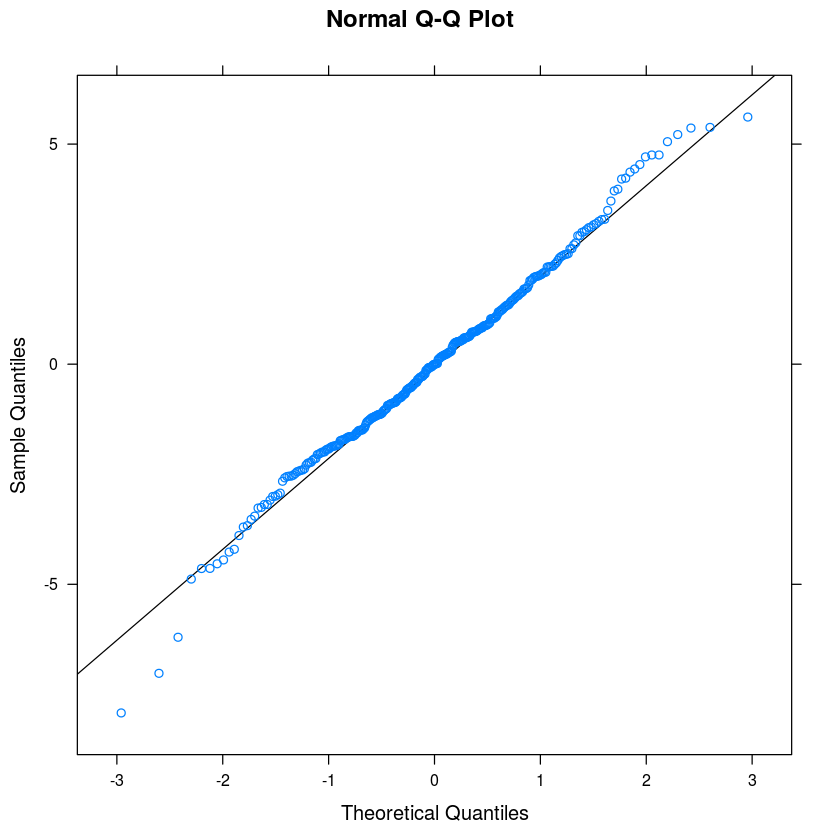

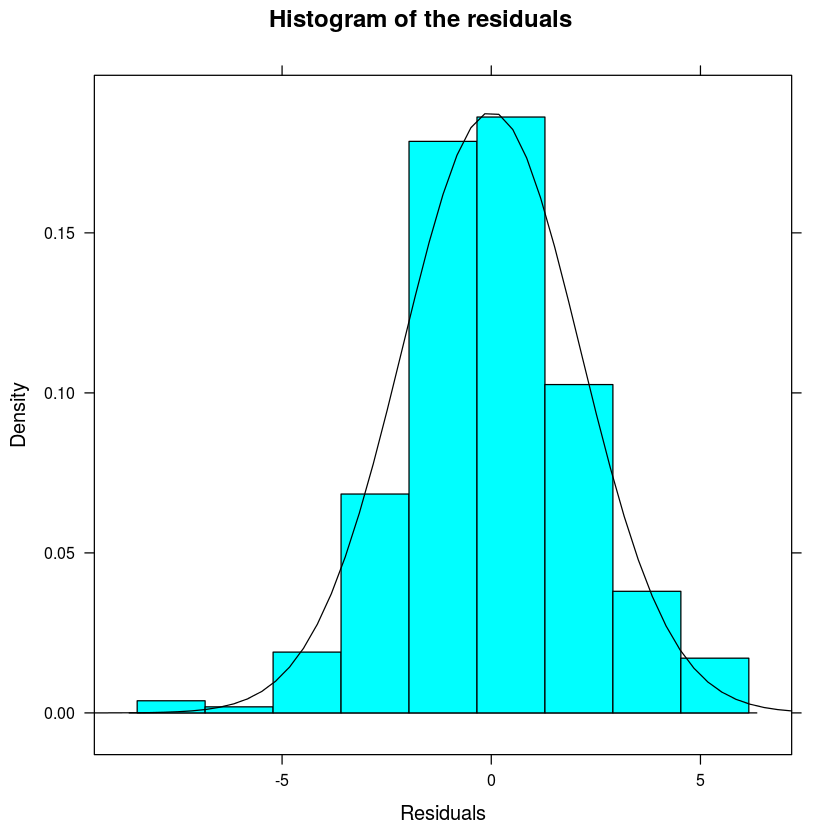

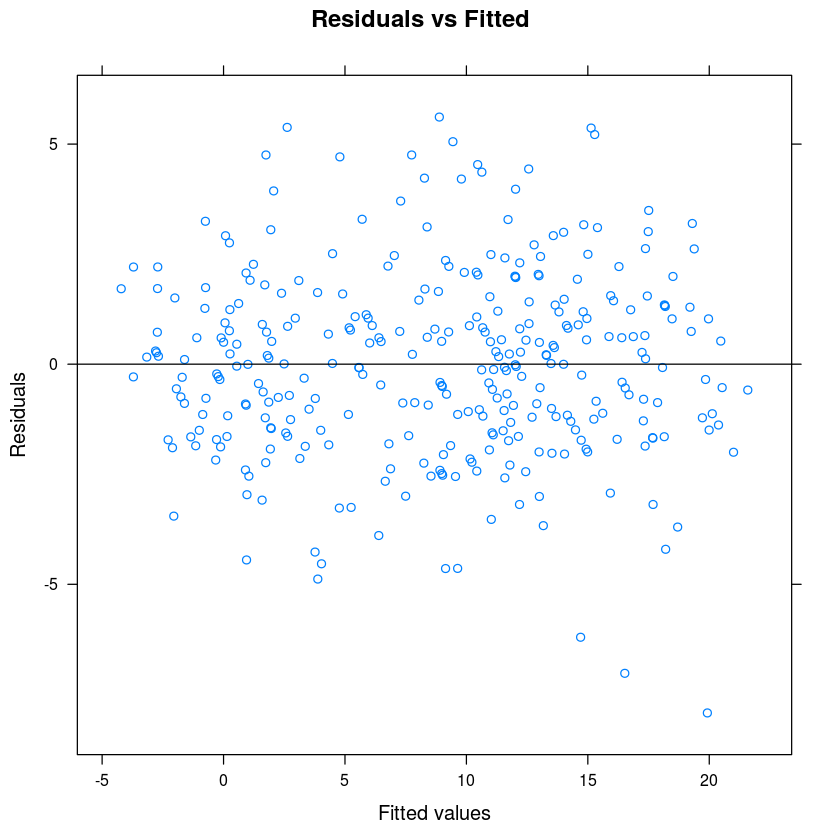

In [82]:

bn.fit.qqplot(fitted$S14.min_t)
bn.fit.histogram(fitted$S14.min_t)
bn.fit.xyplot(fitted$S14.min_t)


In [83]:
df_res_2 <- data.frame(Variable=character(),ME=double(),RMSE=double(),MAE=double(),MPE=double(),MAPE=double(),stringsAsFactors=FALSE)
levels(df_res_2$Variable) <- pred_sensores
str(df_res_2)

'data.frame':	0 obs. of  6 variables:
 $ Variable: atomic  
  ..- attr(*, "levels")= chr  "S10.min_t" "S11.min_t" "S12.min_t" "S13.min_t" ...
 $ ME      : num 
 $ RMSE    : num 
 $ MAE     : num 
 $ MPE     : num 
 $ MAPE    : num 


In [88]:
for(i in 1:length(pred_sensores))
{
    cat("Testing on ",pred_sensores[i],"\n")
    # predicts the value of node pred_sensores[i]  given test set
    pred = predict(fitted_2, pred_sensores[i], testset)  
    # compare the actual and predicted, then print the values
    aux <- accuracy(f = pred, x = testset[,pred_sensores[i]])
    print(cbind(pred, real=testset[, pred_sensores[i]]))
    
    r <- c(as.character(pred_sensores[i]),apply(aux,2,as.double))
    df_res_2 <- rbind.data.frame(df_res_2,r,stringsAsFactors = FALSE) 
}

colnames(df_res_2) <- col

Testing on  S10.min_t 
                pred       real
  [1,] 11.2244377176 10.0000000
  [2,] -3.7508251713 -1.7938724
  [3,]  0.0731384855 -1.0000000
  [4,]  7.3929809006  9.0000000
  [5,]  0.6310882944  2.0000000
  [6,] -0.0973152325 -0.8307821
  [7,] 13.0233113261 10.0000000
  [8,] 20.7923254497 17.5000000
  [9,]  7.8091723293 10.0000000
 [10,]  7.7421808871 10.5000000
 [11,] 11.8613124326  9.5000000
 [12,]  2.2796586245  7.0000000
 [13,]  0.0207033828 -2.2959497
 [14,]  3.2216337376  5.5000000
 [15,] -3.1008226532 -3.0000000
 [16,] -1.4021578477 -1.7579565
 [17,] 11.5946589762 11.5000000
 [18,] -0.4552748299 -1.0000000
 [19,] -3.5851864951 -3.1616533
 [20,]  3.8532812616  4.5000000
 [21,] 16.5677389389 13.0000000
 [22,]  9.3511393292 13.0000000
 [23,]  0.0329300434 -0.9115032
 [24,]  8.4559514251  5.5000000
 [25,] 14.3984119897 13.5000000
 [26,]  3.4676520769  6.5000000
 [27,]  0.0089311581 -0.5000000
 [28,]  0.4948342059  1.5000000
 [29,]  9.1506382148  7.0000000
 [30,] -2.4922988

In [98]:
df_res_2[1:4]

Variable  ME                   RMSE             MAE             
1  S10.min_t 0.172176297145656    2.05460325723664 1.55268338392178
2  S11.min_t 0.0626581318893786   2.05671095029436 1.49254469391706
3  S12.min_t 0.12018503760597     2.02517541447299 1.48620644353094
4  S13.min_t 0.0225633745050309   2.6624360764526  1.55966799797416
5  S14.min_t -0.117637663116795   2.29975172229731 1.52383861380025
6  S15.min_t 0.14209522597945     2.19655771316639 1.60332348307462
7  S16.min_t 0.158580169344579    2.30390837128865 1.68954218165442
8  S18.min_t 0.100287743753373    2.0232239685341  1.48399517282043
9  S19.min_t 0.0571887836699857   2.03431307264245 1.46950398459586
10 S1.min_t  0.00300973027497884  1.84536947153086 1.39233431418537
11 S20.min_t 0.0344569621000568   2.25417425409098 1.63282148720749
12 S2.min_t  0.210540822796221    2.07593636547982 1.54549508678125
13 S3.min_t  0.036816944381769    2.51698515265559 1.5245143469253 
14 S4.min_t  0.0437759422141626   1.90736990975207 1.40770130802234
15 S5.min_t  -0.00301066209663554 2.07954129335324 1.55198040840338
16 S6.min_t  0.169860137708142    1.97575765260901 1.50626941351065
17 S7.min_t  -0.0707625671643967  2.02905980600201 1.50004447649129
18 S8.min_t  -0.0316975170524869  2.36465119040336 1.56841764943405
19 S9.min_t  0.105344588927546    2.03142630182903 1.54444074560537
20 S10.min_t 0.172176297145656    2.05460325723664 1.55268338392178
21 S11.min_t 0.0626581318893786   2.05671095029436 1.49254469391706
22 S12.min_t 0.12018503760597     2.02517541447299 1.48620644353094
23 S13.min_t 0.0225633745050309   2.6624360764526  1.55966799797416
24 S14.min_t -0.117637663116795   2.29975172229731 1.52383861380025
25 S15.min_t 0.14209522597945     2.19655771316639 1.60332348307462
26 S16.min_t 0.158580169344579    2.30390837128865 1.68954218165442
27 S18.min_t 0.100287743753373    2.0232239685341  1.48399517282043
28 S19.min_t 0.0571887836699857   2.03431307264245 1.46950398459586
29 S1.min_t  0.00300973027497884  1.84536947153086 1.39233431418537
30 S20.min_t 0.0344569621000568   2.25417425409098 1.63282148720749
31 S2.min_t  0.210540822796221    2.07593636547982 1.54549508678125
32 S3.min_t  0.036816944381769    2.51698515265559 1.5245143469253 
33 S4.min_t  0.0437759422141626   1.90736990975207 1.40770130802234
34 S5.min_t  -0.00301066209663554 2.07954129335324 1.55198040840338
35 S6.min_t  0.169860137708142    1.97575765260901 1.50626941351065
36 S7.min_t  -0.0707625671643967  2.02905980600201 1.50004447649129
37 S8.min_t  -0.0316975170524869  2.36465119040336 1.56841764943405
38 S9.min_t  0.105344588927546    2.03142630182903 1.54444074560537

In [89]:
for(i in 1:length(pred_sensores))
{
    cat("Confusion matrix helada/no helada",pred_sensores[i],"\n")
    pred = predict(fitted_2, pred_sensores[i], testset)  
    y <- cut(testset[, pred_sensores[i]], breaks = breaks.binario)
    y_pred <- cut(pred, breaks = breaks.binario)
    print(confusionMatrix(y_pred,y))
}

Confusion matrix helada/no helada S10.min_t 
Confusion Matrix and Statistics

          Reference
Prediction (-10,0] (0,50]
   (-10,0]      51      1
   (0,50]       13     90
                                          
               Accuracy : 0.9097          
                 95% CI : (0.8531, 0.9497)
    No Information Rate : 0.5871          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8084          
 Mcnemar's Test P-Value : 0.003283        
                                          
            Sensitivity : 0.7969          
            Specificity : 0.9890          
         Pos Pred Value : 0.9808          
         Neg Pred Value : 0.8738          
             Prevalence : 0.4129          
         Detection Rate : 0.3290          
   Detection Prevalence : 0.3355          
      Balanced Accuracy : 0.8929          
                                          
       'Positive' Class : (-10,0]         
       

In [93]:
for(i in 1:length(pred_sensores))
{
    cat("Confusion matrix ",pred_sensores[i],"\n")    
    pred = predict(fitted_2, pred_sensores[i], testset)  
    y <- cut(testset[, pred_sensores[i]], breaks = my.breaks)
    y_pred <- cut(pred, breaks = my.breaks)
    print(confusionMatrix(y_pred,y))
 
}

Confusion matrix  S10.min_t 
Confusion Matrix and Statistics

          Reference
Prediction (-10,-5] (-5,0] (0,2] (2,5] (5,10] (10,50]
  (-10,-5]        0      0     0     0      0       0
  (-5,0]          0     51     1     0      0       0
  (0,2]           0     11     4     0      0       0
  (2,5]           0      2     2     3      8       0
  (5,10]          0      0     1     3     14       6
  (10,50]         0      0     0     0      6      43

Overall Statistics
                                          
               Accuracy : 0.7419          
                 95% CI : (0.6656, 0.8088)
    No Information Rate : 0.4129          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.644           
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: (-10,-5] Class: (-5,0] Class: (0,2] Class: (2,5]
Sensitivity                       NA        0.7969      0.50000      0.50000

Conclusiones: 
- sumando más datos se disminuye el error RMSE de 2 - 3 que era antes a valores 1.9~2.4
- habria que evaluar la generación de datasets, por ejemplo, dividir entrenamiento de testeo y en el dataset de entrenamiento generar más samples.


Cambiando el ciclo de entrenamiento 


### Intento de modificar ciclo de entrenamiento, generar más ejemplos con smote para el entrenamiento

In [19]:
#genero etiquetas: 1 noche de helada y 0 no helada

Y_class <- as.factor(with(df,ifelse(S20.min_t <= 0,1,0)))

In [20]:
hasta <- round(nrow(df)*.67)
hasta

summary(Y_class[hasta:length(Y_class)])
testset <- df[hasta:nrow(df),]

[1] 310

0   1 
135  19

In [22]:
library(unbalanced)

Loading required package: mlr
Loading required package: ParamHelpers
Warning message:
“replacing previous import ‘BBmisc::isFALSE’ by ‘backports::isFALSE’ when loading ‘mlr’”Loading required package: foreach
Loading required package: doParallel
Loading required package: iterators
Loading required package: parallel


In [23]:

data_smote <- ubBalance(df[1:hasta,],Y_class[1:hasta],type = "ubSMOTE",percOver = 300, percUnder = 150)

In [24]:
summary(data_smote$Y)

0   1 
193 172

In [25]:
nrow(data_smote$X)

[1] 365

In [26]:
ncol(data_smote$X)

[1] 271

### El siguiente bloque tardó demasiado en correr, evaluar correr sin jupyter, en codigo aparte.

In [ ]:
start_time <- Sys.time()
start_time

In [27]:
start_time <- Sys.time()
# learn BN structure on training set data 
res3 = hc(data_smote$X, whitelist=wl,blacklist = bl)
end_time <- Sys.time()
end_time - start_time

Warning message in unique.arcs(whitelist, nodes, warn = TRUE):
“removed 228 duplicate arcs.”

Time difference of 34.14204 mins

In [30]:
start_time <- Sys.time()
fitted_3 = bn.fit(res3, data_smote$X)     # learning of parameters
end_time <- Sys.time()
end_time - start_time

Time difference of 0.2881384 secs

In [37]:
df_res_3 <- data.frame(Variable=character(),ME=double(),RMSE=double(),MAE=double(),MPE=double(),MAPE=double(),stringsAsFactors=FALSE)
levels(df_res_3$Variable) <- pred_sensores
str(df_res_3)

col <- c("Variable","ME","RMSE","MAE","MPE","MAPE")

'data.frame':	0 obs. of  6 variables:
 $ Variable: atomic  
  ..- attr(*, "levels")= chr  "S10.min_t" "S11.min_t" "S12.min_t" "S13.min_t" ...
 $ ME      : num 
 $ RMSE    : num 
 $ MAE     : num 
 $ MPE     : num 
 $ MAPE    : num 


In [38]:
for(i in 1:length(pred_sensores))
{
    cat("Testing on ",pred_sensores[i],"\n")
    # predicts the value of node pred_sensores[i]  given test set
    pred = predict(fitted_3, pred_sensores[i], testset)  
    # compare the actual and predicted, then print the values
    aux <- accuracy(f = pred, x = testset[,pred_sensores[i]])
    print(cbind(pred, real=testset[, pred_sensores[i]]))
    
    r <- c(as.character(pred_sensores[i]),apply(aux,2,as.double))
    df_res_3 <- rbind.data.frame(df_res_3,r,stringsAsFactors = FALSE) 
}

colnames(df_res_3) <- col

Testing on  S10.min_t 
              pred real
  [1,] -0.07193557 -1.0
  [2,]  0.83052511  3.5
  [3,]  1.38649208  2.0
  [4,]  1.61089831  1.5
  [5,]  2.09702080  0.5
  [6,]  0.62725458  1.5
  [7,]  0.45924423  3.5
  [8,]  0.39456659  5.5
  [9,]  1.56082356 -2.5
 [10,] -3.06171981 -4.5
 [11,] -5.55348658 -4.5
 [12,] -2.06657211 -3.0
 [13,] -5.73443237 -2.5
 [14,] -2.12725163 -3.0
 [15,] -0.20145154  1.5
 [16,]  3.04126340  6.0
 [17,]  5.33675620  5.5
 [18,]  5.04602335  4.0
 [19,]  5.14784186  6.5
 [20,]  7.19376931 11.0
 [21,]  5.04217952  0.5
 [22,]  0.53836726 -0.5
 [23,]  0.65901103  1.5
 [24,] -1.13800489 -0.5
 [25,] -2.29599557 -1.0
 [26,] -2.19040979 -1.0
 [27,] -0.63137418  2.0
 [28,] -0.17358032 -2.0
 [29,] -0.44149202 -0.5
 [30,] -0.47492513 -5.0
 [31,]  1.19202581 -1.0
 [32,] -0.67560778 -1.0
 [33,]  4.62980779  2.0
 [34,]  4.18641588  5.5
 [35,]  3.69219229  5.5
 [36,]  5.13212946  8.5
 [37,] 11.53134272  8.0
 [38,]  5.43294142  9.0
 [39,]  8.06194699  9.5
 [40,]  9.1442809

In [39]:
df_res_3

Variable  ME                 RMSE             MAE             
1  S10.min_t -0.810607114680451 3.681783738919   2.81762402530071
2  S11.min_t -0.157081262250167 2.88435184318593 2.2392900048288 
3  S12.min_t 1.16717601328524   3.3362495544802  2.60629802109233
4  S13.min_t -0.212567987045633 6.45440348399715 5.20112596103766
5  S14.min_t -0.311031208347325 3.04999975386125 2.45691767330494
6  S15.min_t -2.29497218775166  5.26834704480861 3.808924828133  
7  S16.min_t 0.354174846947423  3.37721937710083 2.65309421915292
8  S18.min_t -0.428377717109114 4.14279791338646 3.40203508276348
9  S19.min_t -0.938127306634493 3.84022619099318 2.92866695268129
10 S1.min_t  -1.20989169813142  4.41382495901572 3.25401749812007
11 S20.min_t -0.559589075190978 3.10072788042396 2.38819202114671
12 S2.min_t  0.354856720206768  2.92345905729655 2.28099962983064
13 S3.min_t  -0.738915229240879 3.03559362010657 2.36918813113321
14 S4.min_t  2.51881544516174   4.64591885720376 3.64896816402337
15 S5.min_t  -0.486220961668172 3.16020551119032 2.44319507997575
16 S6.min_t  -0.670363451095249 3.93698673112384 3.01928855137186
17 S7.min_t  2.21061517924874   5.09537184735721 4.08017454464254
18 S8.min_t  -2.7195170811807   5.10387265284113 3.90486522412464
19 S9.min_t  0.153778516265987  2.49429736099825 1.922761429828  
   MPE               MAPE            
1  NaN               Inf             
2  -Inf              Inf             
3  -Inf              Inf             
4  NaN               Inf             
5  NaN               Inf             
6  -53.1815611811302 108.089270838451
7  NaN               Inf             
8  NaN               Inf             
9  NaN               Inf             
10 Inf               Inf             
11 NaN               Inf             
12 NaN               Inf             
13 -Inf              Inf             
14 -Inf              Inf             
15 -Inf              Inf             
16 NaN               Inf             
17 -Inf              Inf             
18 NaN               Inf             
19 -Inf              Inf

In [41]:
library(caret)
#llamar confusionMatrix de caret, pasar primero "a factor of predicted classes, then a factor
  # of classes to be used as the true results

breaks.binario <- c(-10,0,50) # caso Helada y no helada
my.breaks <- c(-10,-5,0,2,5,10,50) # rangos de temperatura a analizar

Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘caret’

The following object is masked from ‘package:mlr’:

    train



In [46]:
for(i in 1:length(pred_sensores))
{
    cat("Confusion matrix helada/no helada",pred_sensores[i],"\n")
    pred = predict(fitted_3, pred_sensores[i], testset)  
    y <- cut(testset[, pred_sensores[i]], breaks = breaks.binario)
    y_pred <- cut(pred, breaks = breaks.binario)
    print(confusionMatrix(y_pred,y))
}

Confusion matrix helada/no helada S10.min_t 
Confusion Matrix and Statistics

          Reference
Prediction (-10,0] (0,50]
   (-10,0]      16      4
   (0,50]        4    130
                                          
               Accuracy : 0.9481          
                 95% CI : (0.9002, 0.9773)
    No Information Rate : 0.8701          
    P-Value [Acc > NIR] : 0.001212        
                                          
                  Kappa : 0.7701          
 Mcnemar's Test P-Value : 1.000000        
                                          
            Sensitivity : 0.8000          
            Specificity : 0.9701          
         Pos Pred Value : 0.8000          
         Neg Pred Value : 0.9701          
             Prevalence : 0.1299          
         Detection Rate : 0.1039          
   Detection Prevalence : 0.1299          
      Balanced Accuracy : 0.8851          
                                          
       'Positive' Class : (-10,0]         
       

In [47]:
for(i in 1:length(pred_sensores))
{

    cat("Confusion matrix ",pred_sensores[i],"\n")    
    pred = predict(fitted_3 , pred_sensores[i], testset)
    y <- cut(testset[, pred_sensores[i]], breaks = my.breaks)
    y_pred <- cut(pred, breaks = my.breaks)
    print(confusionMatrix(y_pred,y))
 
}

Confusion matrix  S10.min_t 
Confusion Matrix and Statistics

          Reference
Prediction (-10,-5] (-5,0] (0,2] (2,5] (5,10] (10,50]
  (-10,-5]        0      2     0     0      0       0
  (-5,0]          1     13     3     0      1       0
  (0,2]           0      3     4     3      1       0
  (2,5]           0      0     4    10      5       0
  (5,10]          0      1     4     3     26       9
  (10,50]         0      0     0     0     19      42

Overall Statistics
                                         
               Accuracy : 0.6169         
                 95% CI : (0.5352, 0.694)
    No Information Rate : 0.3377         
    P-Value [Acc > NIR] : 1.394e-12      
                                         
                  Kappa : 0.4825         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: (-10,-5] Class: (-5,0] Class: (0,2] Class: (2,5]
Sensitivity                 0.000000       0.68421      0.26667      0.62500
Specifi